<a href="https://colab.research.google.com/github/hiro111208/data_science/blob/master/iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The purpose of this notebook is to practice essential data scientist skills through the Iris dataset.

In [1]:
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, StandardScaler

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.decomposition import NMF, PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE

import itertools
from __future__ import annotations

In [2]:
pd.set_option("display.max_rows", None)


class AnalyseIris:
    def __init__(self):
        """
        Constructor that loads iris dataset and split indices into designated number of folds
        """

        dataset = load_iris()

        self.df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
        self.df["Label"] = dataset.target

        self.target_names = dataset.target_names

        self.df_test_scores = None

        self.classifiers = dict()

        self.split_indices = self.split_data_index(
            data=self.df.drop(["Label"], axis=1).values, target=self.df.loc[:, "Label"].values, k=5
        )

    def split_data_index(
        self, data: np.ndarray, target: np.ndarray, k: int = 5, random_state: int = 42
    ) -> tuple[tuple[np.ndarray, np.ndarray]]:
        """
        Split data and target into designated number of folds

        Parameters
        ----------
        data : np.ndarray
            data matrix in numpy multi dimensional array

        target : np.ndarray
            target matrix in numpy 1D array

        k : int
            the number of folds to split into

        Returns
        -------
        tuple[tuple[np.ndarray, np.ndarray]]
            tuple each of which contains a split of train indices and test indices

        """

        skf = StratifiedKFold(n_splits=k, random_state=random_state, shuffle=True)

        return tuple([(train_i, test_i) for train_i, test_i in skf.split(data, target)])

    def get(self) -> pd.DataFrame:
        """
        Return data and target from the iris dataset in padas DataFrame

        """

        return self.df

    def pair_plot(self, cmap: str = "brg"):
        """
        Display data and target from the iris dataset in padas DataFrame

        """

        pd.plotting.scatter_matrix(
            self.df.drop(["Label"], axis=1),
            c=self.df.loc[:, "Label"],
            figsize=(15, 15),
            marker="o",
            hist_kwds={"bins": 20},
            s=60,
            alpha=0.8,
            cmap=cmap,
        )
        plt.show()

    def all_supervised(self, n_neighbors: int = 4):
        """
        print test scores of classifiers

        Parameters
        ----------
        n_neighbors:int
            the number of neighbors for KNN

        """

        X, y = self.df.drop(["Label"], axis=1).values, self.df.loc[:, "Label"].values

        self.classifiers = {
            "LogisticRegression": LogisticRegression(),
            "LinearSVC": LinearSVC(),
            "SVC": SVC(),
            "DecisionTreeClassifier": DecisionTreeClassifier(),
            "KNeighborsClassifier": KNeighborsClassifier(n_neighbors),
            "LinearRegression": LinearRegression(),
            "RandomForestClassifier": RandomForestClassifier(),
            "GradientBoostingClassifier": GradientBoostingClassifier(),
            "MLPClassifier": MLPClassifier(),
        }

        self.df_test_scores = pd.DataFrame(
            columns=self.classifiers.keys(), index=range(len(self.split_indices)), dtype="float64"
        )
        for name, clf in self.classifiers.items():
            print(f"=== {name} ===")
            for index, (train_i, test_i) in enumerate(self.split_indices):
                X_train, X_test, y_train, y_test = X[train_i], X[test_i], y[train_i], y[test_i]
                clf.fit(X_train, y_train)
                print(f"test score: {clf.score(X_test, y_test):.3f}, train score: {clf.score(X_train, y_train):.3f}")
                self.df_test_scores.at[index, name] = clf.score(X_test, y_test)
            print()

    def get_supervised(self) -> pd.DataFrame:
        """
        Display the test scores of the classifiers

        Returns
        -------
            pandas data frame storing the test scores of the classifiers

        """

        return self.df_test_scores

    def best_supervised(self) -> tuple[str, float]:
        """
        Return the classifier that returns the best test score and the score

        Returns
        -------
        best_method : str
            the name of the best classifier

        best_score : float
            the test score of the classifier

        """

        best_method = self.df_test_scores.describe().idxmax(axis=1)["mean"]
        best_score = self.df_test_scores.describe().max(axis=1)["mean"]
        return best_method, best_score

    def plot_feature_importances_all(self):
        """
        Display bar charts illustrating the feature importances of each classifier

        """
        trees = [
            "DecisionTreeClassifier",
            "RandomForestClassifier",
            "GradientBoostingClassifier",
        ]

        _, axes = plt.subplots(len(trees), 1, figsize=(4, 12))
        plt.subplots_adjust(wspace=0.4, hspace=0.6)
        for index, clf in enumerate(trees):
            axes[index].barh(
                np.array(self.df.drop(["Label"], axis=1).columns), self.classifiers[clf].feature_importances_
            )
            axes[index].set_xlabel("Feature importance:" + clf)

    def visualize_decision_tree(self):
        """
        Display a decision tree

        Returns
        -------
            the diagram of a decision tree

        """

        return tree.plot_tree(
            self.classifiers["DecisionTreeClassifier"],
            feature_names=self.df.drop(["Label"], axis=1).columns,
            class_names=self.target_names,
            filled=True,
        )

    def plot_scaled_data(self):
        """
        Scale train data, then train LinearSVC using each two features of the scaled train data.
        It then displays train scores and test scores of each classifier with scatter diagrams.

        """
        X, y = self.df.drop(["Label"], axis=1).values, self.df.loc[:, "Label"].values

        scalers = {
            "MinMaxScaler": MinMaxScaler(),
            "StandardScaler": StandardScaler(),
            "RobusScaler": RobustScaler(),
            "Normalizer": Normalizer(),
        }

        clf = LinearSVC()

        for train_i, test_i in self.split_indices:
            X_train, X_test, y_train, y_test = X[train_i], X[test_i], y[train_i], y[test_i]
            clf.fit(X_train, y_train)
            test_score, train_score = "{:.3f}".format(clf.score(X_test, y_test)), "{:.3f}".format(
                clf.score(X_train, y_train)
            )
            print(
                "{0:<15} {1:15} {2:15} {3:15} {4:15}".format(
                    "Original:", "test score:", test_score, "train score:", train_score
                )
            )
            scaled_data = dict()
            for name, scaler in scalers.items():
                scaler.fit(X_train)
                X_train_scaled = scaler.transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                scaled_data[name] = (X_train_scaled, X_test_scaled)

                clf.fit(X_train_scaled, y_train)
                scaled_test_score, scaled_train_score = "{:.3f}".format(
                    clf.score(X_test_scaled, y_test)
                ), "{:.3f}".format(clf.score(X_train_scaled, y_train))
                print(
                    "{0:<15} {1:15} {2:15} {3:15} {4:15}".format(
                        name, "test score:", scaled_test_score, "train score:", scaled_train_score
                    )
                )

            column_names = self.df.drop(["Label"], axis=1).columns

            for feature_1, feature_2 in itertools.combinations(range(len(column_names)), 2):
                _, axes = plt.subplots(1, 5, figsize=(12, 3))
                plt.subplots_adjust(wspace=0.6, hspace=0.8)
                axes[0].scatter(
                    X_train[:, feature_1],
                    X_train[:, feature_2],
                    c="blue",
                    marker="o",
                    label="train",
                )
                axes[0].scatter(
                    X_test[:, feature_1],
                    X_test[:, feature_2],
                    c="red",
                    marker="^",
                    label="test",
                )
                axes[0].set_title("Original")
                axes[0].set_xlabel(column_names[feature_1])
                axes[0].set_ylabel(column_names[feature_2])
                axes[0].legend(loc="best")

                for index, (name, (X_train_scaled, X_test_scaled)) in enumerate(scaled_data.items()):
                    axes[index + 1].scatter(
                        X_train_scaled[:, feature_1], X_train_scaled[:, feature_2], c="blue", marker="o"
                    )
                    axes[index + 1].scatter(
                        X_test_scaled[:, feature_1], X_test_scaled[:, feature_2], c="red", marker="^"
                    )
                    axes[index + 1].set_title(name)
                    axes[index + 1].set_xlabel(column_names[feature_1])
                    axes[index + 1].set_ylabel(column_names[feature_2])
                plt.show()
            print("=========================================================================")

    def plot_feature_histogram(self):
        """
        Display histograms of each feature whose x axis is magnitude and y axis is frequency

        """

        setosa = self.df[self.df.loc[:, "Label"] == 0].drop(["Label"], axis=1).values
        versicolor = self.df[self.df.loc[:, "Label"] == 1].drop(["Label"], axis=1).values
        virginica = self.df[self.df.loc[:, "Label"] == 2].drop(["Label"], axis=1).values
        _, axes = plt.subplots(len(self.df.drop(["Label"], axis=1).columns), 1, figsize=(8, 16))
        plt.subplots_adjust(wspace=0.4, hspace=0.6)

        column_names = self.df.drop(["Label"], axis=1).columns

        for i in range(len(column_names)):
            bins = 50
            axes[i].hist(setosa[:, i], bins=bins, color="blue", alpha=0.5)
            axes[i].hist(versicolor[:, i], bins=bins, color="red", alpha=0.5)
            axes[i].hist(virginica[:, i], bins=bins, color="green", alpha=0.5)
            axes[i].set_title(column_names[i])
            axes[i].set_yticks(())
            axes[i].set_title(column_names[i])
        axes[0].set_xlabel("Feature magnitude")
        axes[0].set_ylabel("Frequency")
        axes[0].legend(self.target_names, loc="best")
        plt.show()

    def plot_pca(self, n_components: int = 2) -> tuple[pd.DataFrame, pd.DataFrame, PCA]:
        """
        Display a scatter diagram and a heat map of PCA

        Parameters
        ----------
        n_components: int
            the number of components

        """

        scaler = StandardScaler()
        scaler.fit(self.df.drop(["Label"], axis=1).values)
        X_scaled = scaler.transform(self.df.drop(["Label"], axis=1).values)

        pca = PCA(n_components)
        pca.fit(X_scaled)

        X_pca = pca.transform(X_scaled)

        markers = ["o", "^", "v"]
        for i in range(3):
            d = X_pca[self.df.loc[:, "Label"] == i, :]
            plt.plot(d[:, 0], d[:, 1], "o", marker=markers[i])
        plt.xlabel("First principal component")
        plt.ylabel("Second principal component")
        plt.legend(self.target_names)

        plt.matshow(pca.components_, cmap="viridis")
        plt.yticks([0, 1], ["First component", "Second component"])
        plt.colorbar()
        plt.xticks(
            range(len(self.df.drop(["Label"], axis=1).columns)),
            self.df.drop(["Label"], axis=1).columns,
            rotation=60,
            ha="left",
        )
        plt.xlabel("Feature")
        plt.ylabel("Principal components")

        return pd.DataFrame(X_scaled, columns=self.df.drop(["Label"], axis=1).columns), pd.DataFrame(X_pca), pca

    def plot_nmf(self, n_components: int = 2) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Display a scatter diagram and a heat map of NMF

        Parameters
        ----------
        n_components: int
            the number of components

        """

        X_scaled = self.df.drop(["Label"], axis=1).values

        nmf = NMF(n_components)
        nmf.fit(X_scaled)

        X_nmf = nmf.transform(X_scaled)

        markers = ["o", "^", "v"]
        for i in range(len(self.target_names)):
            d = X_nmf[self.df.loc[:, "Label"] == i, :]
            plt.plot(d[:, 0], d[:, 1], "o", marker=markers[i])
        plt.xlabel("First component")
        plt.ylabel("Second component")
        plt.legend(self.target_names)

        plt.matshow(nmf.components_, cmap="viridis")
        plt.yticks([0, 1], ["First component", "Second component"])
        plt.colorbar()
        plt.xticks(
            range(len(self.df.drop(["Label"], axis=1).columns)),
            self.df.drop(["Label"], axis=1).columns,
            rotation=60,
            ha="left",
        )
        plt.xlabel("Feature")
        plt.ylabel("NMF components")

        return pd.DataFrame(X_scaled, columns=self.df.drop(["Label"], axis=1).columns), pd.DataFrame(X_nmf), nmf

    def plot_tsne(self):
        """
        Display a scatter diagram and a heat map of t-SNE

        """

        tsne = TSNE(random_state=42)
        iris_tsne = tsne.fit_transform(self.df.drop(["Label"], axis=1).values)

        plt.xlim(iris_tsne[:, 0].min(), iris_tsne[:, 0].max() + 1)
        plt.ylim(iris_tsne[:, 1].min(), iris_tsne[:, 1].max() + 1)
        for i in range(len(self.df.drop(["Label"], axis=1))):
            plt.text(
                iris_tsne[i, 0],
                iris_tsne[i, 1],
                str(self.df.loc[:, "Label"][i]),
                fontdict={"weight": "bold", "size": 9},
            )
        plt.xlabel("t-SNE feature 0")
        plt.ylabel("t-SNE feature 1")

    def plot_k_means(self):
        """
        Display a scatter diagram and a heat map of kMeans

        """

        scaler = StandardScaler()
        scaler.fit(self.df.drop(["Label"], axis=1).values)
        X_scaled = scaler.transform(self.df.drop(["Label"], axis=1).values)

        pca = PCA(2)
        pca.fit(X_scaled)

        X = pca.transform(X_scaled)

        kmeans = KMeans(n_clusters=3)
        kmeans.fit(X)
        centers = kmeans.cluster_centers_
        assignments = {"Label predicted from K-Means:": kmeans.labels_, "Actual label:": self.df.loc[:, "Label"].values}
        markers = ["o", "^", "v"]
        colors = ["blue", "red", "green"]
        for text, assignment in assignments.items():
            print(text)
            print(assignment)
            plt.figure()
            plt.scatter(centers[:, 0], centers[:, 1], c="black", marker="*", s=500)
            for i in set(assignment):
                plt.scatter(X[assignment == i, 0], X[assignment == i, 1], c=colors[i], marker=markers[i])
            plt.xlabel("First principal component")
            plt.ylabel("Second principal component")

            plt.show()

    def plot_dendrogram(self, truncate: bool = False):
        """
        Display a dendrogram

        Parameters
        ----------
        truncate: bool
            With True, limit the number of clusters at the bottom of a dendrogram

        """

        dist_sin = linkage(
            self.df.drop(["Label"], axis=1).loc[:, self.df.drop(["Label"], axis=1).columns], method="ward"
        )
        plt.figure(figsize=(18, 10))
        if truncate:
            truncate_mode = "lastp"
            p = 10
        else:
            truncate_mode = None
            p = 0
        dendrogram(dist_sin, leaf_rotation=90, truncate_mode=truncate_mode, p=p)
        bounds = plt.xlim()
        plt.plot(bounds, [10, 10], "--", c="k")
        plt.plot(bounds, [6, 6], "--", c="k")
        plt.text(bounds[1], 10, " 3 clusters", va="center", fontdict={"size": 20})
        plt.text(bounds[1], 6, " 4 clusters", va="center", fontdict={"size": 20})

        plt.xlabel("Sample")
        plt.ylabel("ClusterDistance")
        plt.suptitle("DENDROGRAM COMPLETE METHOD", fontsize=25)

        plt.show()

    def plot_dbscan(self, scaling: bool = False, eps: float = 0.5, min_samples: int = 5):
        """
        Display a scatter diagram and a heat map of DBSCAN

        Parameters
        ----------
        scaling: bool
            With true, traing data is scaled

        eps: float
            the maximum distance between two datapoints for one to be considered as in the neighborhood of the other

        min_samples:
            the number of samples in a neighborhood for a point to be considered as a core point
        """

        X = self.df.drop(["Label"], axis=1).values
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)

        if scaling:
            scaler = StandardScaler()
            scaler.fit(X)
            X = scaler.transform(X)

        clusters = dbscan.fit_predict(X)
        plt.scatter(X[:, 2], X[:, 3], c=clusters, cmap="brg")
        plt.xlabel("Feature 2")
        plt.ylabel("Feature 3")

        print(f"Cluster Memberships: {dbscan.labels_}")

## Chapter 1

In [3]:
iris = AnalyseIris()
iris.get()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
5                  5.4               3.9                1.7               0.4   
6                  4.6               3.4                1.4               0.3   
7                  5.0               3.4                1.5               0.2   
8                  4.4               2.9                1.4               0.2   
9                  4.9               3.1                1.5               0.1   
10                 5.4               3.7                1.5               0.2   
11                 4.8               3.4                1.6               0.2   
12                 4.8               3.0                1.4               0.1   
13                 4.3               3.0                1.1               0.1   
14                 5.8               4.0                1.2               0.2   
15                 5.7               4.4                1.5               0.4   
16                 5.4               3.9                1.3               0.4   
17                 5.1               3.5                1.4               0.3   
18                 5.7               3.8                1.7               0.3   
19                 5.1               3.8                1.5               0.3   
20                 5.4               3.4                1.7               0.2   
21                 5.1               3.7                1.5               0.4   
22                 4.6               3.6                1.0               0.2   
23                 5.1               3.3                1.7               0.5   
24                 4.8               3.4                1.9               0.2   
25                 5.0               3.0                1.6               0.2   
26                 5.0               3.4                1.6               0.4   
27                 5.2               3.5                1.5               0.2   
28                 5.2               3.4                1.4               0.2   
29                 4.7               3.2                1.6               0.2   
30                 4.8               3.1                1.6               0.2   
31                 5.4               3.4                1.5               0.4   
32                 5.2               4.1                1.5               0.1   
33                 5.5               4.2                1.4               0.2   
34                 4.9               3.1                1.5               0.2   
35                 5.0               3.2                1.2               0.2   
36                 5.5               3.5                1.3               0.2   
37                 4.9               3.6                1.4               0.1   
38                 4.4               3.0                1.3               0.2   
39                 5.1               3.4                1.5               0.2   
40                 5.0               3.5                1.3               0.3   
41                 4.5               2.3                1.3               0.3   
42                 4.4               3.2                1.3               0.2   
43                 5.0               3.5                1.6               0.6   
44                 5.1               3.8                1.9               0.4   
45                 4.8               3.0                1.4               0.3   
46                 5.1               3.8                1.6               0.2   
47                 4.6               3.2                1.4               0.2   
48                 5.3              

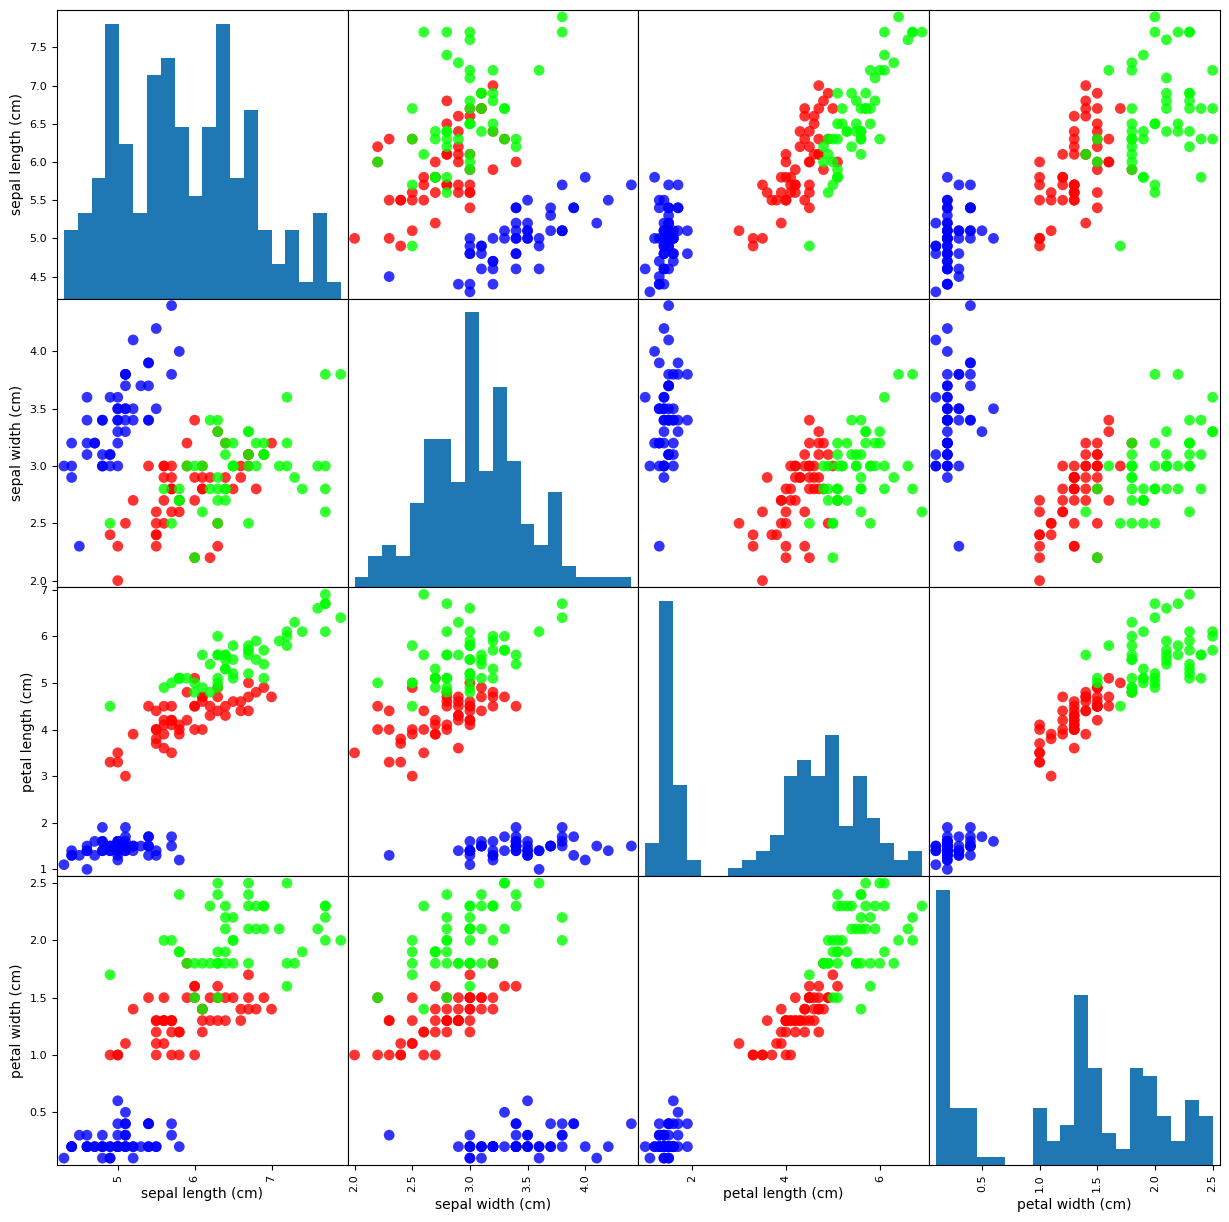

In [4]:
iris.pair_plot() # Observe raw data

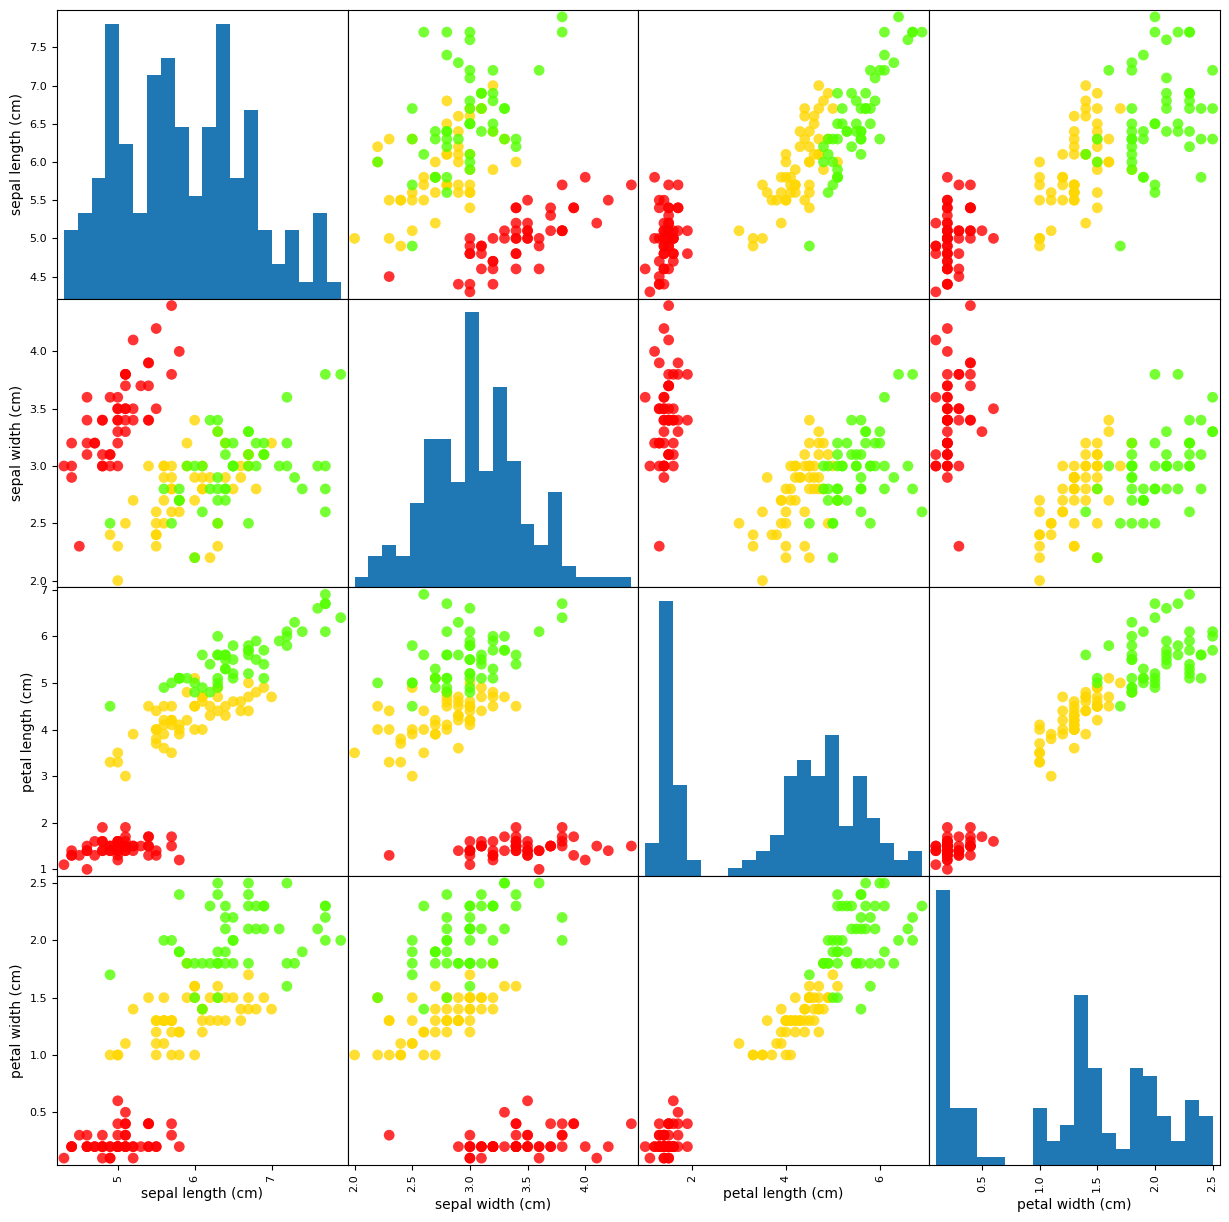

In [5]:
iris.pair_plot(cmap="prism")

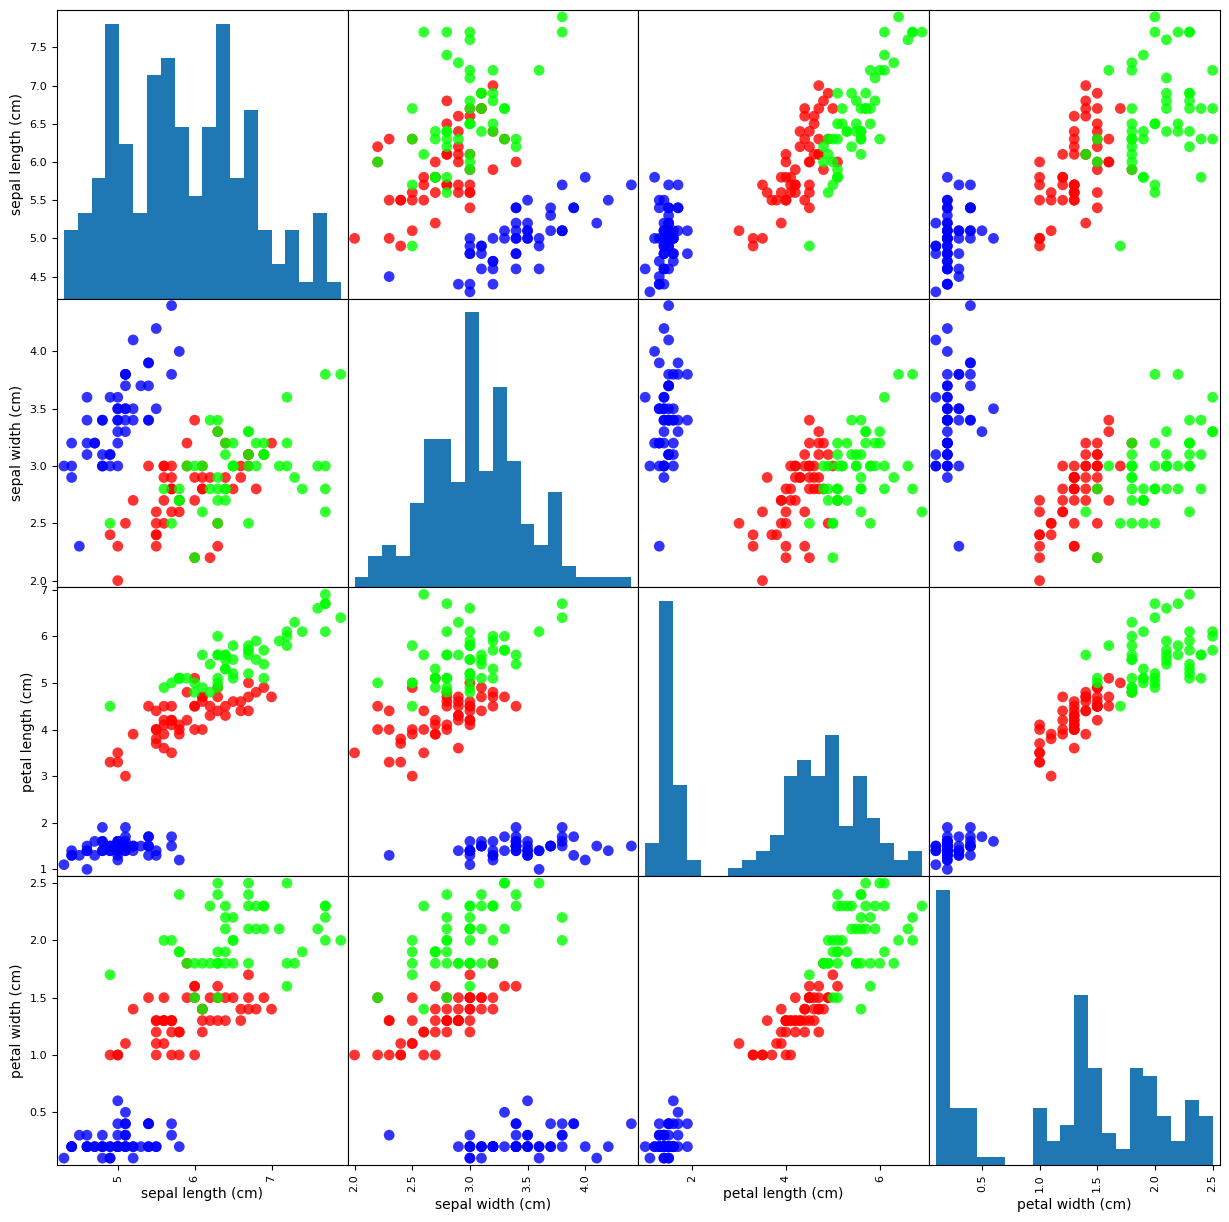

In [6]:
iris.pair_plot(cmap="brg")

## chapter 2

In [7]:
iris.all_supervised(n_neighbors=4)

=== LogisticRegression ===
test score: 1.000, train score: 0.967


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

test score: 0.967, train score: 0.975
test score: 0.933, train score: 0.992
test score: 1.000, train score: 0.975


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

test score: 0.933, train score: 0.967

=== LinearSVC ===
test score: 1.000, train score: 0.958
test score: 1.000, train score: 0.967
test score: 0.867, train score: 0.983
test score: 0.933, train score: 0.958
test score: 0.933, train score: 0.967

=== SVC ===
test score: 1.000, train score: 0.975
test score: 0.967, train score: 0.950
test score: 0.933, train score: 0.983
test score: 1.000, train score: 0.975
test score: 0.933, train score: 0.950

=== DecisionTreeClassifier ===
test score: 1.000, train score: 1.000
test score: 0.967, train score: 1.000
test score: 0.933, train score: 1.000
test score: 0.967, train score: 1.000
test score: 0.900, train score: 1.000

=== KNeighborsClassifier ===
test score: 1.000, train score: 0.958
test score: 0.967, train score: 0.967
test score: 0.933, train score: 0.983
test score: 1.000, train score: 0.950
test score: 0.933, train score: 0.967

=== LinearRegression ===
test score: 0.940, train score: 0.927
test score: 0.948, train score: 0.925
test s

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


test score: 1.000, train score: 0.967


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


test score: 1.000, train score: 0.967


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


test score: 0.933, train score: 0.992


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


test score: 0.967, train score: 0.967
test score: 1.000, train score: 0.975



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
iris.get_supervised()

LogisticRegression  LinearSVC       SVC  DecisionTreeClassifier  \
0            1.000000   1.000000  1.000000                1.000000   
1            0.966667   1.000000  0.966667                0.966667   
2            0.933333   0.866667  0.933333                0.933333   
3            1.000000   0.933333  1.000000                0.966667   
4            0.933333   0.933333  0.933333                0.900000   

   KNeighborsClassifier  LinearRegression  RandomForestClassifier  \
0              1.000000          0.940195                1.000000   
1              0.966667          0.948169                0.966667   
2              0.933333          0.885736                0.933333   
3              1.000000          0.938339                0.966667   
4              0.933333          0.906368                0.900000   

   GradientBoostingClassifier  MLPClassifier  
0                    1.000000       1.000000  
1                    0.966667       1.000000  
2                    0.933333       0.933333  
3                    0.966667       0.966667  
4                    0.900000       1.000000

In [9]:
iris.get_supervised().describe()

LogisticRegression  LinearSVC       SVC  DecisionTreeClassifier  \
count            5.000000   5.000000  5.000000                5.000000   
mean             0.966667   0.946667  0.966667                0.953333   
std              0.033333   0.055777  0.033333                0.038006   
min              0.933333   0.866667  0.933333                0.900000   
25%              0.933333   0.933333  0.933333                0.933333   
50%              0.966667   0.933333  0.966667                0.966667   
75%              1.000000   1.000000  1.000000                0.966667   
max              1.000000   1.000000  1.000000                1.000000   

       KNeighborsClassifier  LinearRegression  RandomForestClassifier  \
count              5.000000          5.000000                5.000000   
mean               0.966667          0.923761                0.953333   
std                0.033333          0.026584                0.038006   
min                0.933333          0.885736                0.900000   
25%                0.933333          0.906368                0.933333   
50%                0.966667          0.938339                0.966667   
75%                1.000000          0.940195                0.966667   
max                1.000000          0.948169                1.000000   

       GradientBoostingClassifier  MLPClassifier  
count                    5.000000       5.000000  
mean                     0.953333       0.980000  
std                      0.038006       0.029814  
min                      0.900000       0.933333  
25%                      0.933333       0.966667  
50%                      0.966667       1.000000  
75%                      0.966667       1.000000  
max                      1.000000       1.000000

In [10]:
best_method, best_score = iris.best_supervised()
print("Best Method is ", best_method, " : ", "{0:0.4f}".format(best_score))

Best Method is  MLPClassifier  :  0.9800


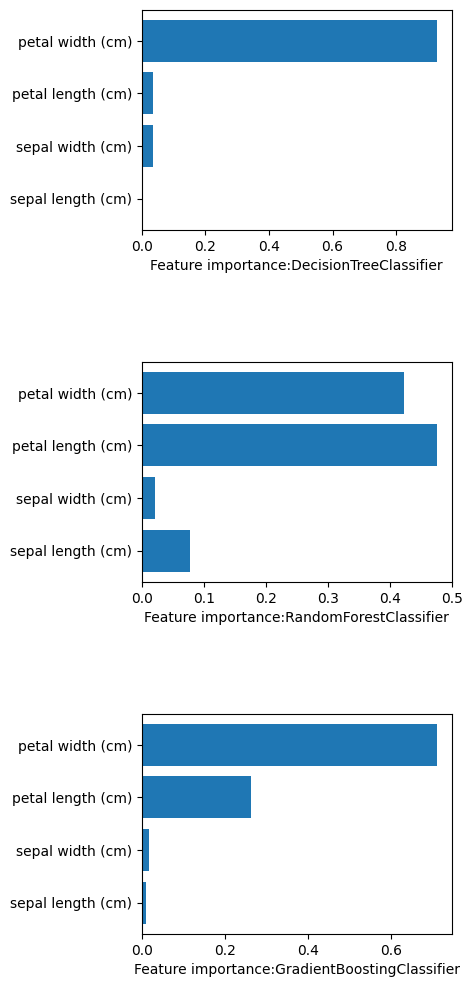

In [11]:
iris.plot_feature_importances_all()

[Text(0.4, 0.9, 'petal width (cm) <= 0.75\ngini = 0.667\nsamples = 120\nvalue = [40, 40, 40]\nclass = setosa'),
 Text(0.3, 0.7, 'gini = 0.0\nsamples = 40\nvalue = [40, 0, 0]\nclass = setosa'),
 Text(0.5, 0.7, 'petal width (cm) <= 1.65\ngini = 0.5\nsamples = 80\nvalue = [0, 40, 40]\nclass = versicolor'),
 Text(0.2, 0.5, 'petal length (cm) <= 5.0\ngini = 0.093\nsamples = 41\nvalue = [0, 39, 2]\nclass = versicolor'),
 Text(0.1, 0.3, 'gini = 0.0\nsamples = 38\nvalue = [0, 38, 0]\nclass = versicolor'),
 Text(0.3, 0.3, 'sepal width (cm) <= 2.75\ngini = 0.444\nsamples = 3\nvalue = [0, 1, 2]\nclass = virginica'),
 Text(0.2, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]\nclass = versicolor'),
 Text(0.4, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2]\nclass = virginica'),
 Text(0.8, 0.5, 'petal length (cm) <= 4.85\ngini = 0.05\nsamples = 39\nvalue = [0, 1, 38]\nclass = virginica'),
 Text(0.7, 0.3, 'sepal width (cm) <= 3.1\ngini = 0.375\nsamples = 4\nvalue = [0, 1, 3]\nclass = virginica'),
 

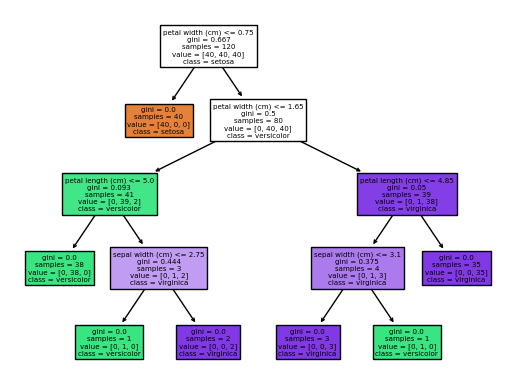

In [12]:
graph = iris.visualize_decision_tree() # only last fold taken account
graph

## Chapter 3

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Original:       test score:     1.000           train score:    0.958          
MinMaxScaler    test score:     0.967           train score:    0.933          
StandardScaler  test score:     0.967           train score:    0.942          
RobusScaler     test score:     0.967           train score:    0.933          
Normalizer      test score:     0.900           train score:    0.908          


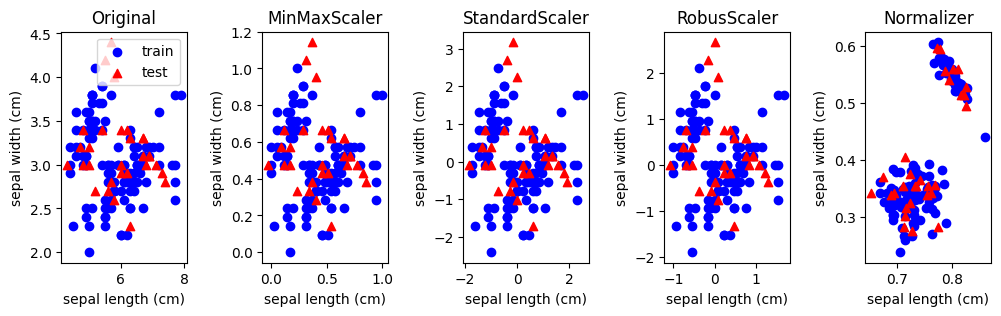

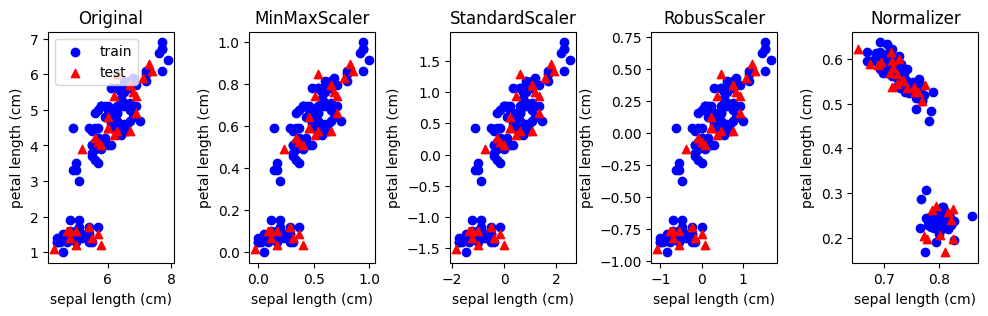

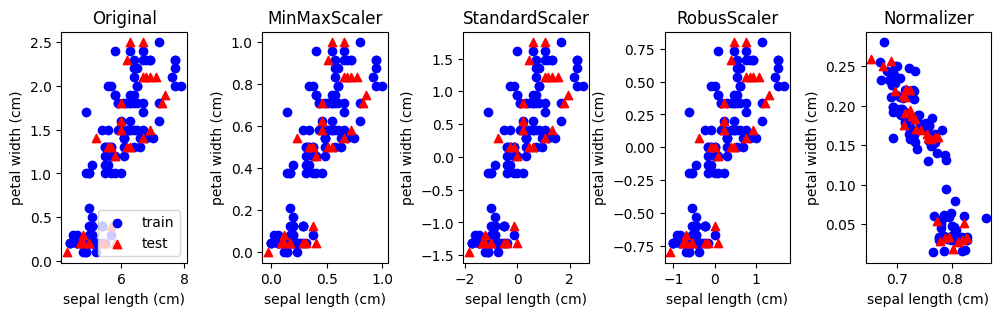

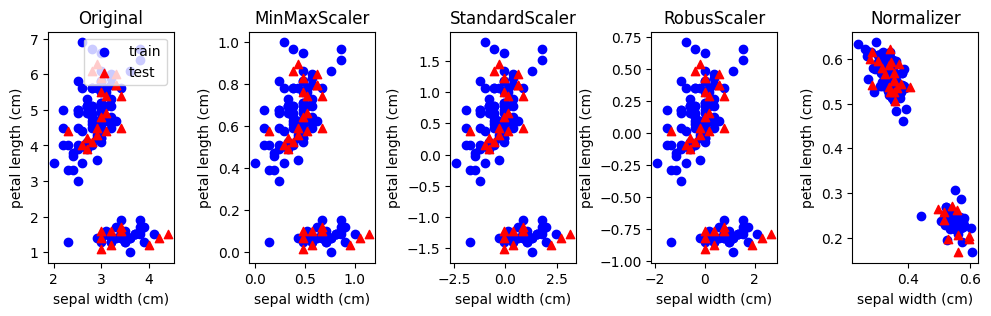

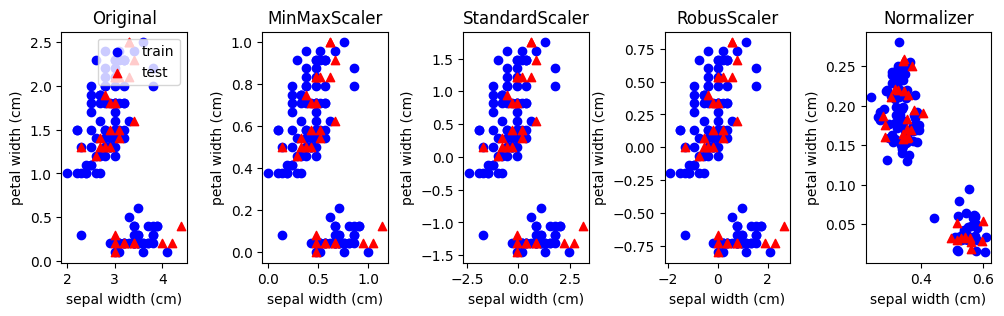

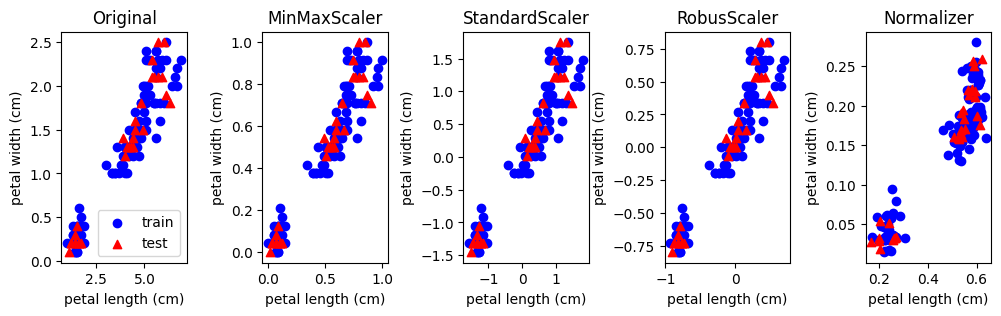

Original:       test score:     1.000           train score:    0.967          
MinMaxScaler    test score:     0.967           train score:    0.925          
StandardScaler  test score:     0.967           train score:    0.950          
RobusScaler     test score:     0.967           train score:    0.950          
Normalizer      test score:     0.933           train score:    0.892          


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


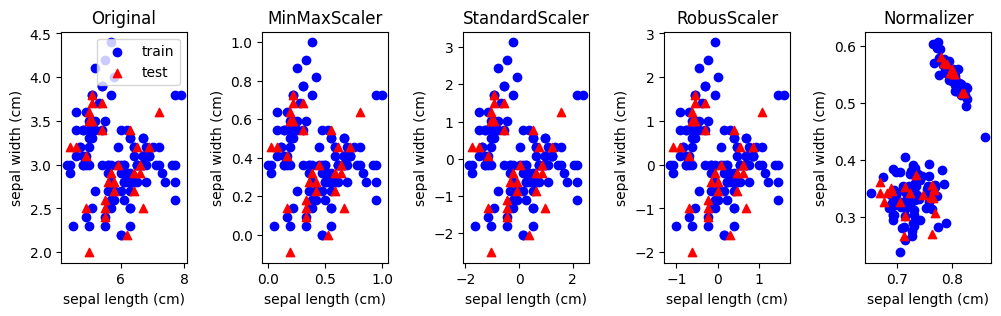

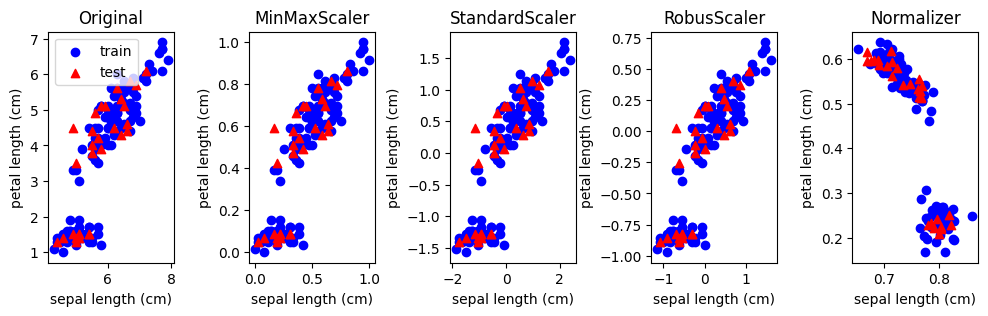

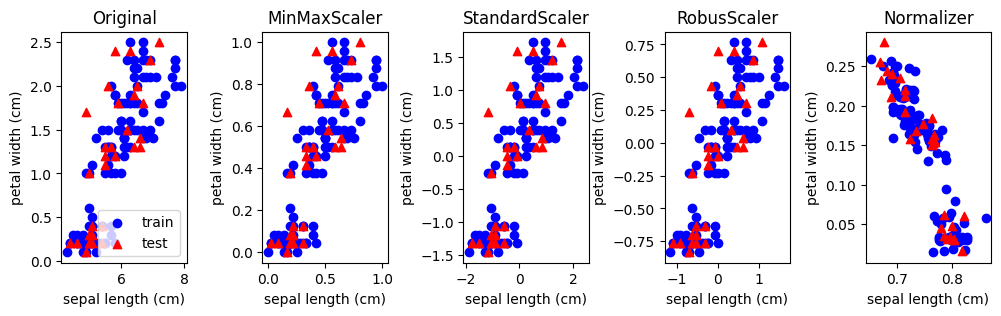

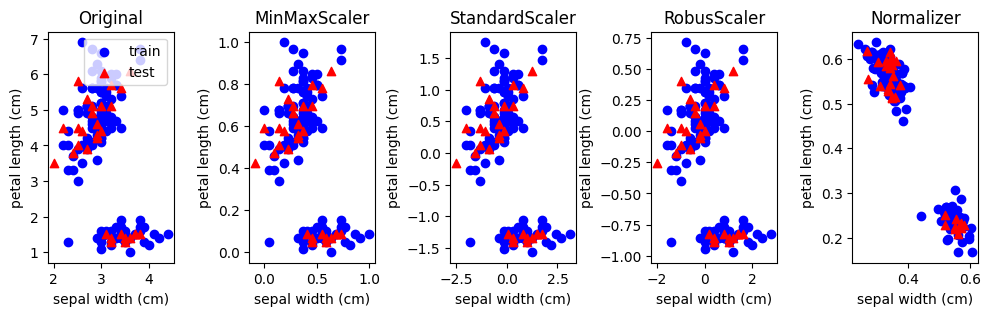

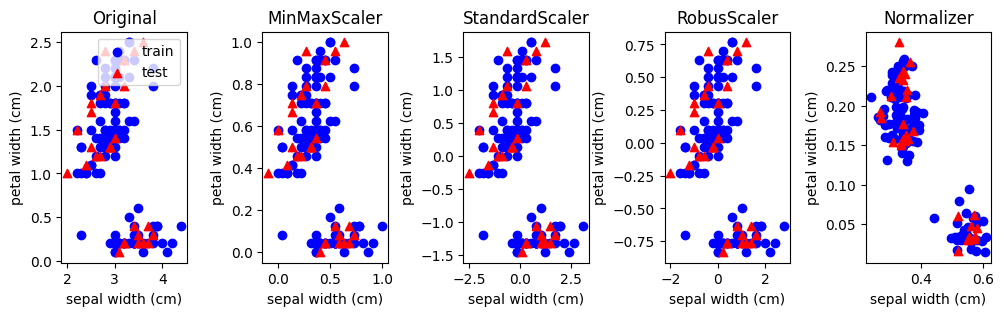

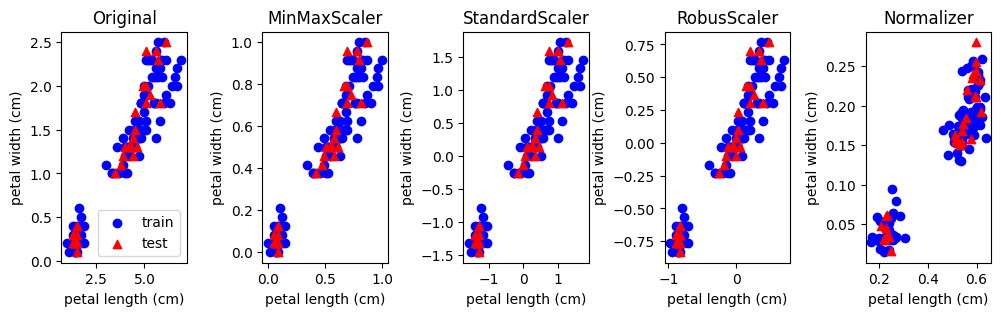

Original:       test score:     0.867           train score:    0.983          
MinMaxScaler    test score:     0.867           train score:    0.958          
StandardScaler  test score:     0.833           train score:    0.958          
RobusScaler     test score:     0.833           train score:    0.958          
Normalizer      test score:     0.833           train score:    0.925          


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


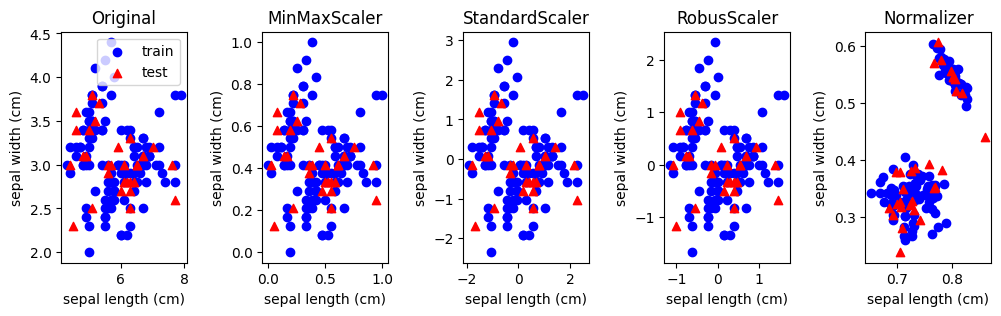

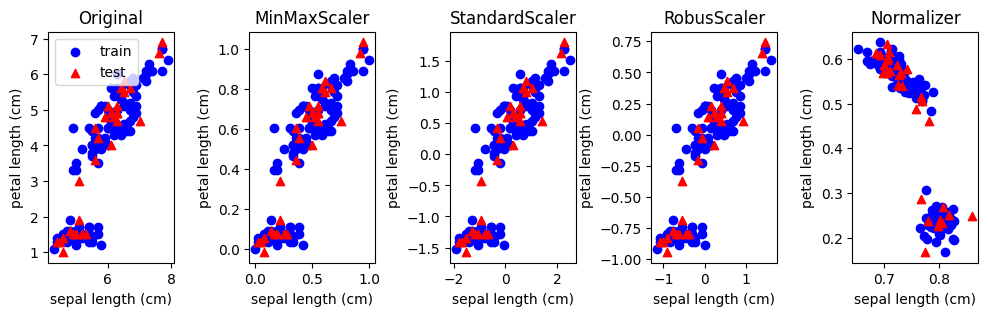

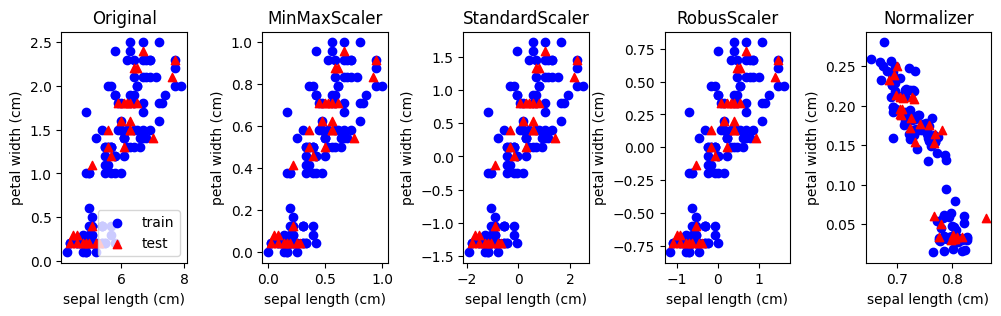

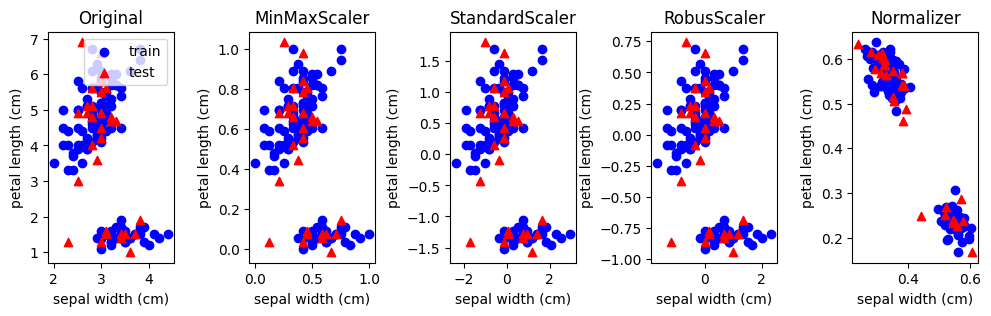

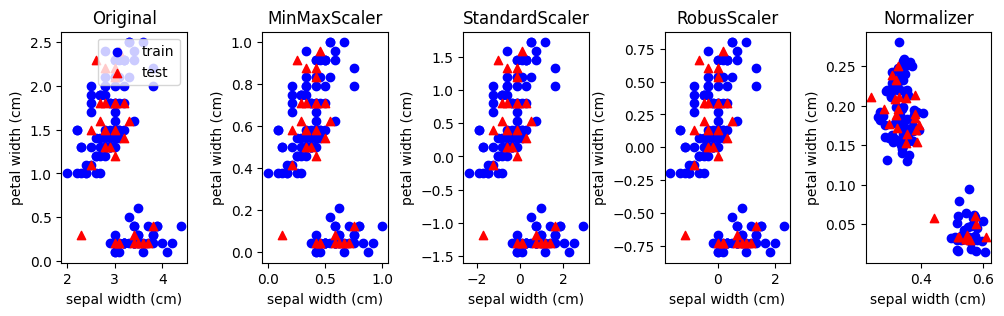

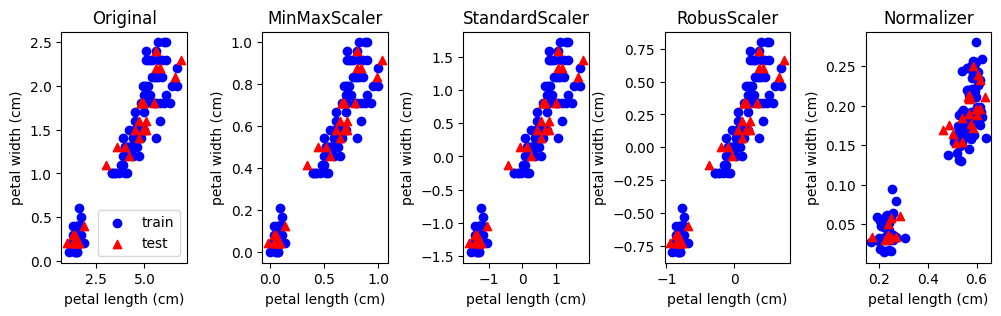

Original:       test score:     0.933           train score:    0.958          
MinMaxScaler    test score:     0.967           train score:    0.925          
StandardScaler  test score:     0.967           train score:    0.933          
RobusScaler     test score:     0.967           train score:    0.925          
Normalizer      test score:     0.833           train score:    0.917          


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


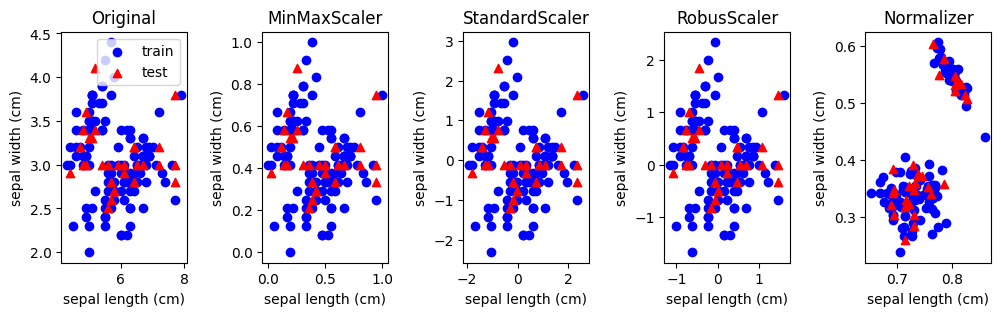

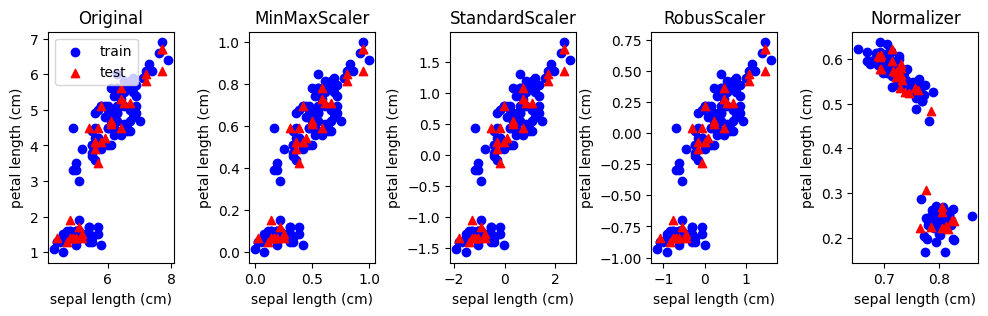

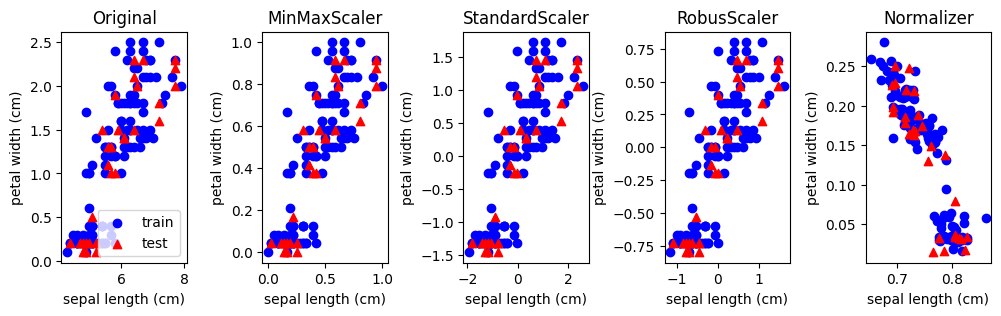

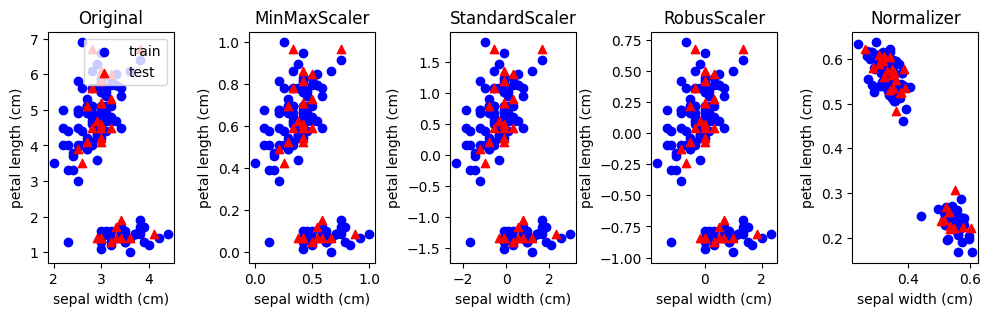

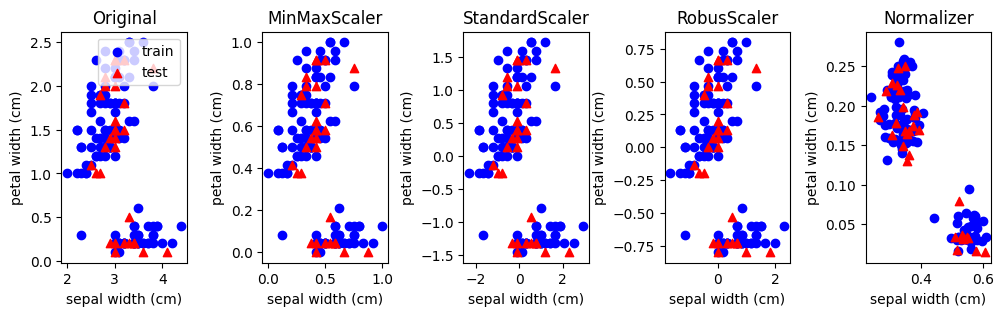

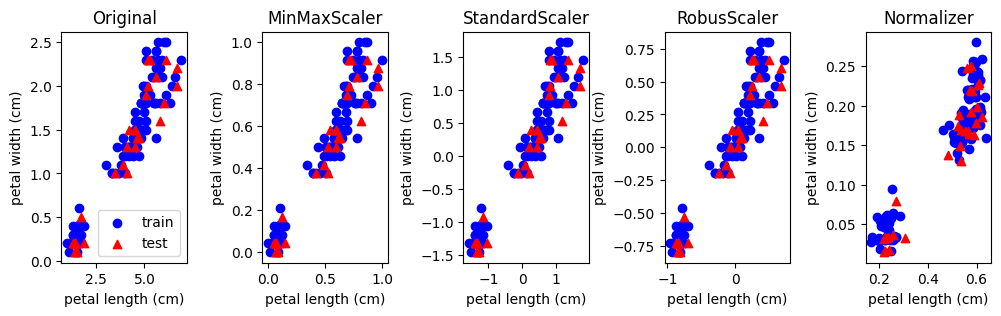

Original:       test score:     0.933           train score:    0.967          
MinMaxScaler    test score:     0.867           train score:    0.942          
StandardScaler  test score:     0.900           train score:    0.958          
RobusScaler     test score:     0.900           train score:    0.958          
Normalizer      test score:     0.967           train score:    0.900          


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


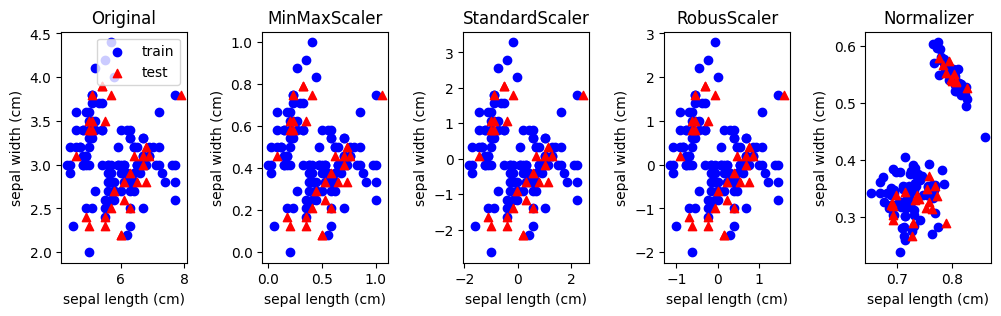

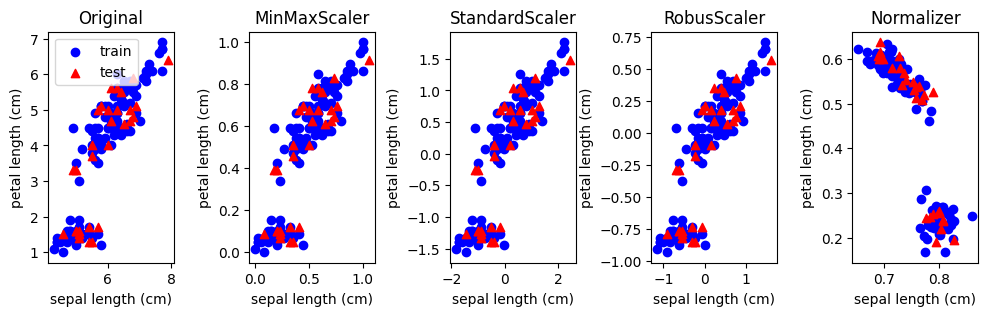

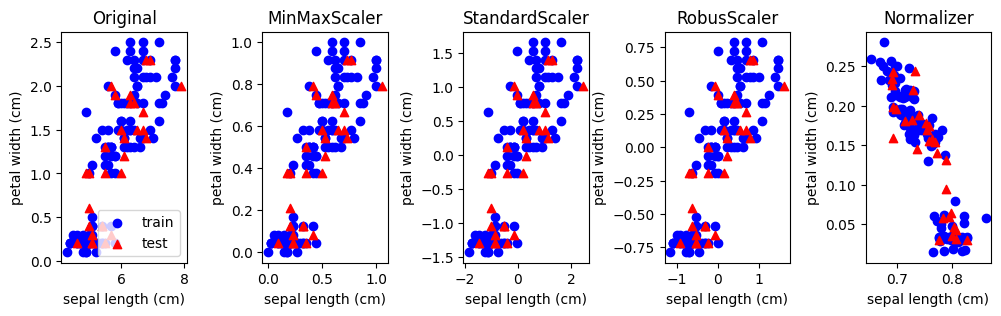

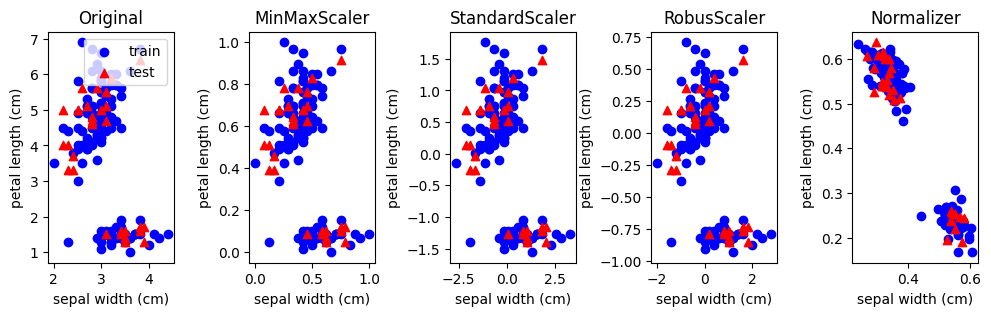

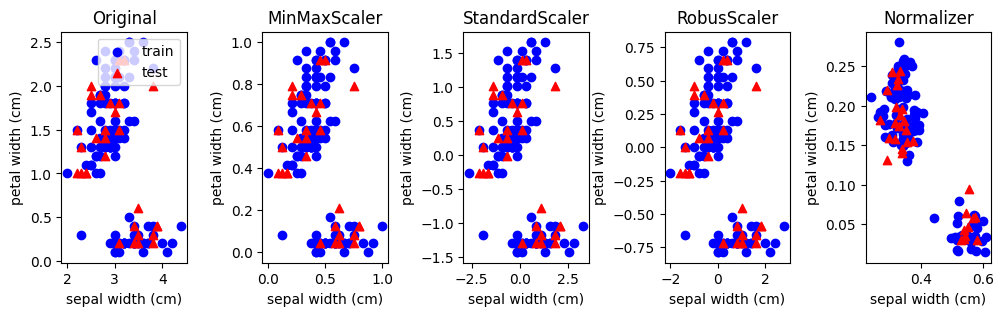

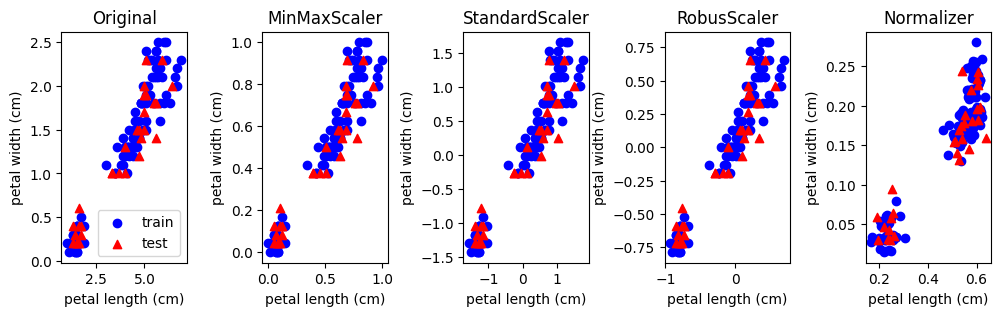

In [13]:
iris.plot_scaled_data()

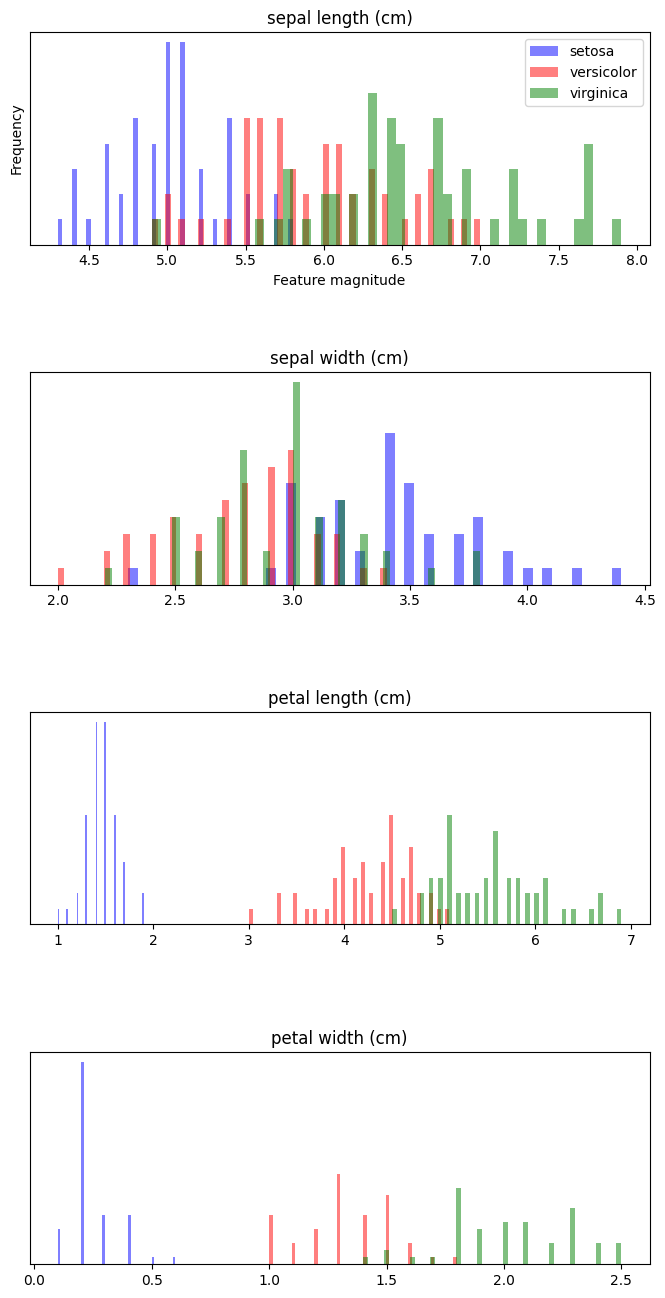

In [14]:
iris.plot_feature_histogram() # colour

<ipython-input-2-d198c1cc58e7>:314: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(d[:, 0], d[:, 1], "o", marker=markers[i])


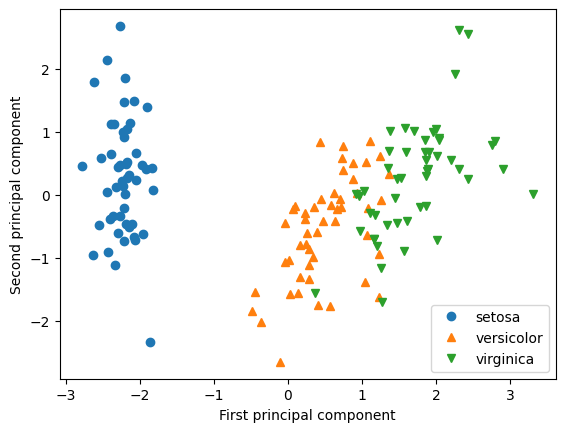

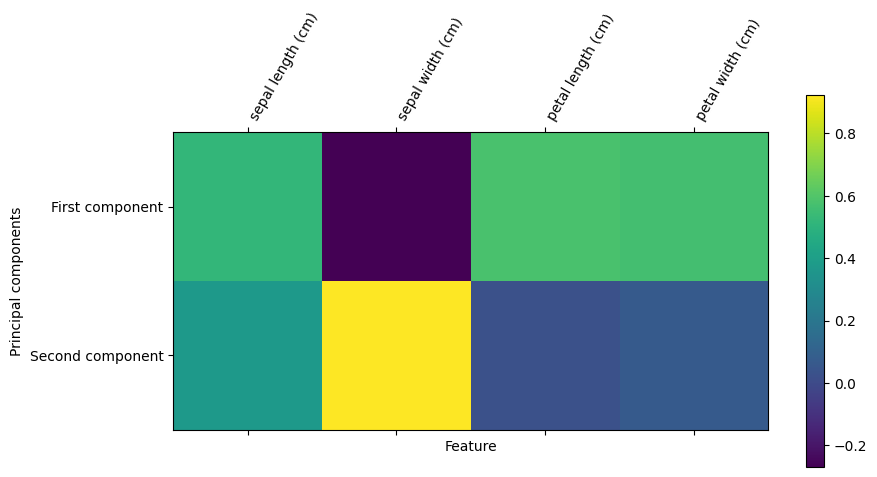

In [15]:
X_scaled, df_pca, X_pca = iris.plot_pca()

In [16]:
X_scaled

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0            -0.900681          1.019004          -1.340227         -1.315444
1            -1.143017         -0.131979          -1.340227         -1.315444
2            -1.385353          0.328414          -1.397064         -1.315444
3            -1.506521          0.098217          -1.283389         -1.315444
4            -1.021849          1.249201          -1.340227         -1.315444
5            -0.537178          1.939791          -1.169714         -1.052180
6            -1.506521          0.788808          -1.340227         -1.183812
7            -1.021849          0.788808          -1.283389         -1.315444
8            -1.748856         -0.362176          -1.340227         -1.315444
9            -1.143017          0.098217          -1.283389         -1.447076
10           -0.537178          1.479398          -1.283389         -1.315444
11           -1.264185          0.788808          -1.226552         -1.315444
12           -1.264185         -0.131979          -1.340227         -1.447076
13           -1.870024         -0.131979          -1.510739         -1.447076
14           -0.052506          2.169988          -1.453901         -1.315444
15           -0.173674          3.090775          -1.283389         -1.052180
16           -0.537178          1.939791          -1.397064         -1.052180
17           -0.900681          1.019004          -1.340227         -1.183812
18           -0.173674          1.709595          -1.169714         -1.183812
19           -0.900681          1.709595          -1.283389         -1.183812
20           -0.537178          0.788808          -1.169714         -1.315444
21           -0.900681          1.479398          -1.283389         -1.052180
22           -1.506521          1.249201          -1.567576         -1.315444
23           -0.900681          0.558611          -1.169714         -0.920548
24           -1.264185          0.788808          -1.056039         -1.315444
25           -1.021849         -0.131979          -1.226552         -1.315444
26           -1.021849          0.788808          -1.226552         -1.052180
27           -0.779513          1.019004          -1.283389         -1.315444
28           -0.779513          0.788808          -1.340227         -1.315444
29           -1.385353          0.328414          -1.226552         -1.315444
30           -1.264185          0.098217          -1.226552         -1.315444
31           -0.537178          0.788808          -1.283389         -1.052180
32           -0.779513          2.400185          -1.283389         -1.447076
33           -0.416010          2.630382          -1.340227         -1.315444
34           -1.143017          0.098217          -1.283389         -1.315444
35           -1.021849          0.328414          -1.453901         -1.315444
36           -0.416010          1.019004          -1.397064         -1.315444
37           -1.143017          1.249201          -1.340227         -1.447076
38           -1.748856         -0.131979          -1.397064         -1.315444
39           -0.900681          0.788808          -1.283389         -1.315444
40           -1.021849          1.019004          -1.397064         -1.183812
41           -1.627688         -1.743357          -1.397064         -1.183812
42           -1.748856          0.328414          -1.397064         -1.315444
43           -1.021849          1.019004          -1.226552         -0.788916
44           -0.900681          1.709595          -1.056039         -1.052180
45           -1.264185         -0.131979          -1.340227         -1.183812
46           -0.900681          1.709595          -1.226552         -1.315444
47           -1.506521          0.328414          -1.340227         -1.315444
48           -0.658345          1.479398          -1.283389         -1.315444
49           -1.021849          0.558611          -1.340227         -1.315444
50            1.401508     

In [17]:
df_pca

0         1
0   -2.264703  0.480027
1   -2.080961 -0.674134
2   -2.364229 -0.341908
3   -2.299384 -0.597395
4   -2.389842  0.646835
5   -2.075631  1.489178
6   -2.444029  0.047644
7   -2.232847  0.223148
8   -2.334640 -1.115328
9   -2.184328 -0.469014
10  -2.166310  1.043691
11  -2.326131  0.133078
12  -2.218451 -0.728676
13  -2.633101 -0.961507
14  -2.198741  1.860057
15  -2.262215  2.686284
16  -2.207588  1.483609
17  -2.190350  0.488838
18  -1.898572  1.405019
19  -2.343369  1.127849
20  -1.914323  0.408856
21  -2.207013  0.924121
22  -2.774345  0.458344
23  -1.818670  0.085559
24  -2.227163  0.137254
25  -1.951846 -0.625619
26  -2.051151  0.242164
27  -2.168577  0.527150
28  -2.139563  0.313218
29  -2.265261 -0.337732
30  -2.140122 -0.504541
31  -1.831595  0.423695
32  -2.614948  1.793576
33  -2.446177  2.150728
34  -2.109975 -0.460202
35  -2.207809 -0.206107
36  -2.045146  0.661558
37  -2.527332  0.592293
38  -2.429633 -0.904180
39  -2.169711  0.268879
40  -2.286475  0.441715
41  -1.858122 -2.337415
42  -2.553638 -0.479101
43  -1.964448  0.472327
44  -2.137059  1.142229
45  -2.069744 -0.711053
46  -2.384733  1.120430
47  -2.394376 -0.386247
48  -2.229447  0.997960
49  -2.203833  0.009216
50   1.101781  0.862972
51   0.731337  0.594615
52   1.240979  0.616298
53   0.407483 -1.754404
54   1.075475 -0.208421
55   0.388687 -0.593284
56   0.746530  0.773019
57  -0.487323 -1.852429
58   0.927902  0.032226
59   0.011426 -1.034018
60  -0.110196 -2.654073
61   0.440693 -0.063295
62   0.562108 -1.764724
63   0.719562 -0.186225
64  -0.033355 -0.439003
65   0.875407  0.509064
66   0.350252 -0.196312
67   0.158810 -0.792096
68   1.225094 -1.622244
69   0.164918 -1.302609
70   0.737683  0.396572
71   0.476287 -0.417320
72   1.234178 -0.933326
73   0.632858 -0.416388
74   0.702661 -0.063412
75   0.874274  0.250793
76   1.256509 -0.077256
77   1.358405  0.331312
78   0.664800 -0.225928
79  -0.040259 -1.058719
80   0.130795 -1.562272
81   0.023453 -1.572476
82   0.241538 -0.777256
83   1.061095 -0.633843
84   0.223979 -0.287774
85   0.429139  0.845582
86   1.048728  0.522052
87   1.044531 -1.382989
88   0.069588 -0.219503
89   0.283477 -1.329325
90   0.279078 -1.120029
91   0.624570  0.024923
92   0.336530 -0.988404
93  -0.362183 -2.019238
94   0.288586 -0.855730
95   0.091361 -0.181192
96   0.227717 -0.384920
97   0.576388 -0.154874
98  -0.447667 -1.543792
99   0.256731 -0.598852
100  1.844569  0.870421
101  1.157882 -0.698870
102  2.205267  0.562010
103  1.440151 -0.046988
104  1.867812  0.295045
105  2.751873  0.800409
106  0.367018 -1.561503
107  2.302439  0.420066
108  2.006686 -0.711439
109  2.259777  1.921010
110  1.364175  0.692756
111  1.602679 -0.421700
112  1.883901  0.419250
113  1.260115 -1.162260
114  1.467645 -0.442272
115  1.590077  0.676245
116  1.471431  0.255622
117  2.426329  2.556661
118  3.310696  0.017781
119  1.263767 -1.706745
120  2.037716  0.910467
121  0.977981 -0.571764
122  2.897651  0.413641
123  1.333232 -0.481811
124  1.700734  1.013922
125  1.954327  1.007778
126  1.175104 -0.316394
127  1.020951  0.064346
128  1.788350 -0.187361
129  1.863648  0.562291
130  2.435954  0.259284
131  2.304928  2.626323
132  1.862703 -0.178549
133  1.114148 -0.292923
134  1.202473 -0.811315
135  2.798770  0.856803
136  1.576256  1.068581
137  1.346292  0.422431
138  0.924825  0.017223
139  1.852045  0.676128
140  2.014810  0.613886
141  1.901784  0.689575
142  1.157882 -0.698870
143  2.040558  0.867521
144  1.998147  1.049169
145  1.870503  0.386966
146  1.564580 -0.896687
147  1.521170  0.269069
148  1.372788  1.011254
149  0.960656 -0.024332

In [18]:
X_pca.components_
# By observing the outcome of the first principal component, it can be evaluated that only sepal width is singed differently from the other features and its impact on this component is minimal. There is no significant differences of impacts on the component among the other three features.
# By observing the outcome of the second principal component, all the features are in the same sign and the impact of sepal width on this component is the most significant.


array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199]])

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
<ipython-input-2-d198c1cc58e7>:354: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(d[:, 0], d[:, 1], "o", marker=markers[i])


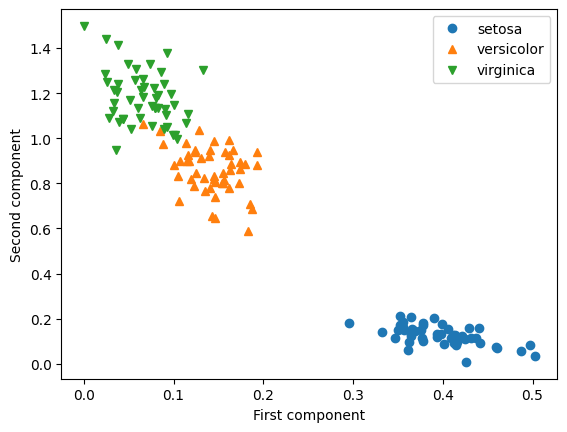

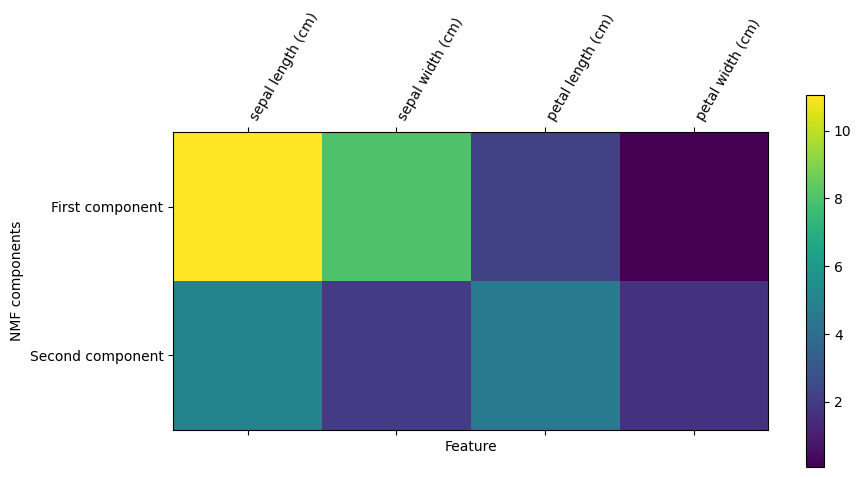

In [19]:
X_scaled, df_nmf, X_nmf = iris.plot_nmf(n_components=2)

In [20]:
X_scaled

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
5                  5.4               3.9                1.7               0.4
6                  4.6               3.4                1.4               0.3
7                  5.0               3.4                1.5               0.2
8                  4.4               2.9                1.4               0.2
9                  4.9               3.1                1.5               0.1
10                 5.4               3.7                1.5               0.2
11                 4.8               3.4                1.6               0.2
12                 4.8               3.0                1.4               0.1
13                 4.3               3.0                1.1               0.1
14                 5.8               4.0                1.2               0.2
15                 5.7               4.4                1.5               0.4
16                 5.4               3.9                1.3               0.4
17                 5.1               3.5                1.4               0.3
18                 5.7               3.8                1.7               0.3
19                 5.1               3.8                1.5               0.3
20                 5.4               3.4                1.7               0.2
21                 5.1               3.7                1.5               0.4
22                 4.6               3.6                1.0               0.2
23                 5.1               3.3                1.7               0.5
24                 4.8               3.4                1.9               0.2
25                 5.0               3.0                1.6               0.2
26                 5.0               3.4                1.6               0.4
27                 5.2               3.5                1.5               0.2
28                 5.2               3.4                1.4               0.2
29                 4.7               3.2                1.6               0.2
30                 4.8               3.1                1.6               0.2
31                 5.4               3.4                1.5               0.4
32                 5.2               4.1                1.5               0.1
33                 5.5               4.2                1.4               0.2
34                 4.9               3.1                1.5               0.2
35                 5.0               3.2                1.2               0.2
36                 5.5               3.5                1.3               0.2
37                 4.9               3.6                1.4               0.1
38                 4.4               3.0                1.3               0.2
39                 5.1               3.4                1.5               0.2
40                 5.0               3.5                1.3               0.3
41                 4.5               2.3                1.3               0.3
42                 4.4               3.2                1.3               0.2
43                 5.0               3.5                1.6               0.6
44                 5.1               3.8                1.9               0.4
45                 4.8               3.0                1.4               0.3
46                 5.1               3.8                1.6               0.2
47                 4.6               3.2                1.4               0.2
48                 5.3               3.7                1.5               0.2
49                 5.0               3.3                1.4               0.2
50                 7.0     

In [21]:
df_nmf

0         1
0    0.413500  0.104673
1    0.365449  0.140978
2    0.377800  0.101885
3    0.349981  0.148964
4    0.415896  0.095306
5    0.428787  0.156932
6    0.376340  0.114074
7    0.393239  0.131392
8    0.332135  0.141321
9    0.369285  0.144418
10   0.436498  0.113820
11   0.375375  0.148744
12   0.364142  0.130416
13   0.361053  0.061815
14   0.502432  0.035167
15   0.497108  0.081410
16   0.459021  0.075490
17   0.409654  0.113731
18   0.440542  0.160248
19   0.424742  0.110503
20   0.398733  0.178129
21   0.413347  0.127424
22   0.425519  0.007849
23   0.364188  0.208654
24   0.352699  0.209825
25   0.355484  0.183203
26   0.377989  0.169869
27   0.411094  0.126537
28   0.411104  0.114040
29   0.355124  0.162966
30   0.352728  0.172332
31   0.406159  0.155525
32   0.460234  0.070303
33   0.486954  0.055650
34   0.365439  0.153476
35   0.400817  0.086036
36   0.441670  0.090329
37   0.414589  0.084744
38   0.347243  0.113098
39   0.398392  0.132896
40   0.412060  0.091867
41   0.295707  0.178699
42   0.362341  0.097372
43   0.377846  0.180122
44   0.390662  0.201003
45   0.356450  0.148533
46   0.421029  0.121806
47   0.365088  0.120741
48   0.431345  0.112316
49   0.393249  0.118894
50   0.193171  0.937427
51   0.173525  0.896741
52   0.161506  0.993565
53   0.104693  0.834050
54   0.140923  0.950056
55   0.114951  0.899547
56   0.156958  0.937153
57   0.145773  0.647466
58   0.161317  0.925581
59   0.123144  0.786785
60   0.105613  0.721142
61   0.155339  0.843865
62   0.134446  0.822259
63   0.124148  0.947479
64   0.185375  0.706937
65   0.192839  0.879697
66   0.117204  0.900434
67   0.154327  0.800297
68   0.087729  0.972359
69   0.140195  0.781352
70   0.113547  0.977476
71   0.173356  0.803761
72   0.085295  1.031717
73   0.124291  0.937225
74   0.173687  0.861492
75   0.180138  0.886055
76   0.145111  0.986230
77   0.128401  1.036896
78   0.130267  0.914312
79   0.186977  0.684494
80   0.135051  0.767351
81   0.146456  0.737932
82   0.161753  0.777693
83   0.065971  1.061258
84   0.106899  0.897426
85   0.164166  0.884057
86   0.166318  0.949836
87   0.115682  0.927524
88   0.155131  0.800876
89   0.119791  0.818325
90   0.100952  0.882845
91   0.139256  0.919256
92   0.146645  0.805916
93   0.143377  0.656833
94   0.124925  0.844824
95   0.156571  0.813682
96   0.145176  0.830603
97   0.163382  0.858483
98   0.182458  0.590589
99   0.145186  0.818105
100  0.024083  1.283361
101  0.044128  1.085425
102  0.065601  1.262388
103  0.051043  1.169963
104  0.038397  1.242062
105  0.038455  1.412431
106  0.035697  0.947335
107  0.049661  1.327526
108  0.026341  1.248150
109  0.085547  1.293669
110  0.114097  1.065698
111  0.059928  1.135169
112  0.080377  1.176435
113  0.027589  1.088344
114  0.032447  1.122853
115  0.082289  1.132089
116  0.076456  1.144748
117  0.092595  1.380452
118  0.000000  1.498368
119  0.039630  1.071153
120  0.077819  1.221050
121  0.052642  1.042891
122  0.024797  1.440962
123  0.088855  1.043166
124  0.082754  1.192063
125  0.089831  1.241353
126  0.098810  1.013439
127  0.101196  1.016570
128  0.037109  1.206504
129  0.097542  1.198241
130  0.058536  1.305230
131  0.133269  1.304262
132  0.033263  1.215562
133  0.092825  1.048849
134  0.033473  1.154310
135  0.073709  1.330249
136  0.065713  1.184999
137  0.078852  1.135381
138  0.103602  0.994705
139  0.100638  1.149716
140  0.063677  1.214603
141  0.115622  1.106751
142  0.044128  1.085425
143  0.057549  1.260267
144  0.067370  1.228296
145  0.090208  1.131966
146  0.062353  1.088310
147  0.091440  1.101783
148  0.079523  1.133716
149  0.075773  1.054282

In [22]:
X_nmf.components_ # 第1成分において、sepal lengthの影響力が一番大きく、他3つの特徴量の影響力はそれぞれ異なる。第2成分において最も影響力のある特徴量もsepal lengthだが、負荷量は第1成分の時の半分ほどである。また、第2成分の特徴量の影響力は第1成分のほどばらつきがない。
# By observing the first component, it can be said that sepal length is the most influential in this component.
# By observing the second component, it is clear that sepal length is the most influential in this component as well. However, the influence of each feature in this component is not as varied as that of the first component.

array([[11.05547983,  7.96828449,  2.22911407,  0.07051629],
       [ 5.0075179 ,  2.01368146,  4.58653481,  1.64561552]])

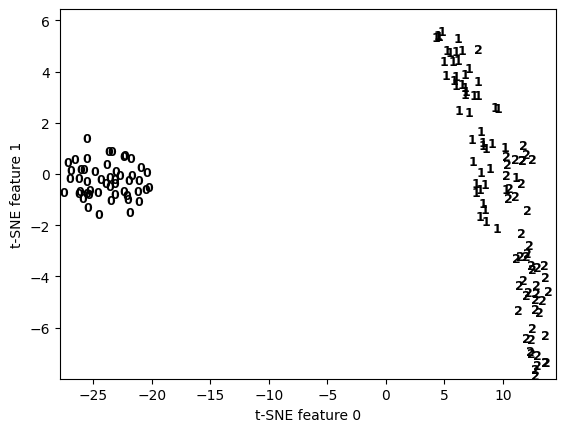

In [23]:
iris.plot_tsne()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Label predicted from K-Means:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0
 0 2 2 2 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 0 2 2
 0 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 2 2 2 2 2 2 0 0 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


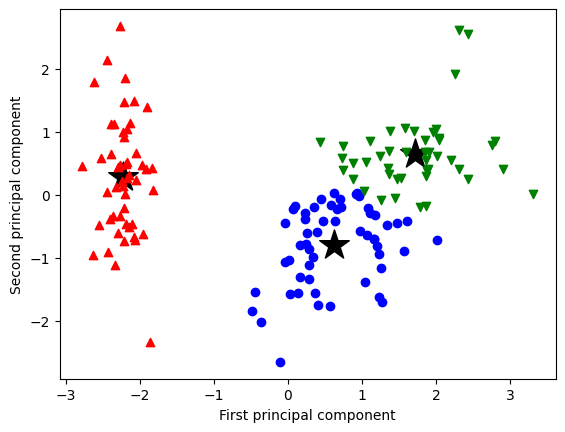

Actual label:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


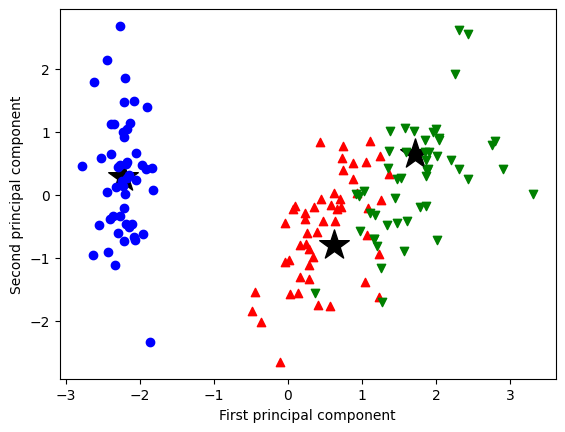

In [24]:
iris.plot_k_means()

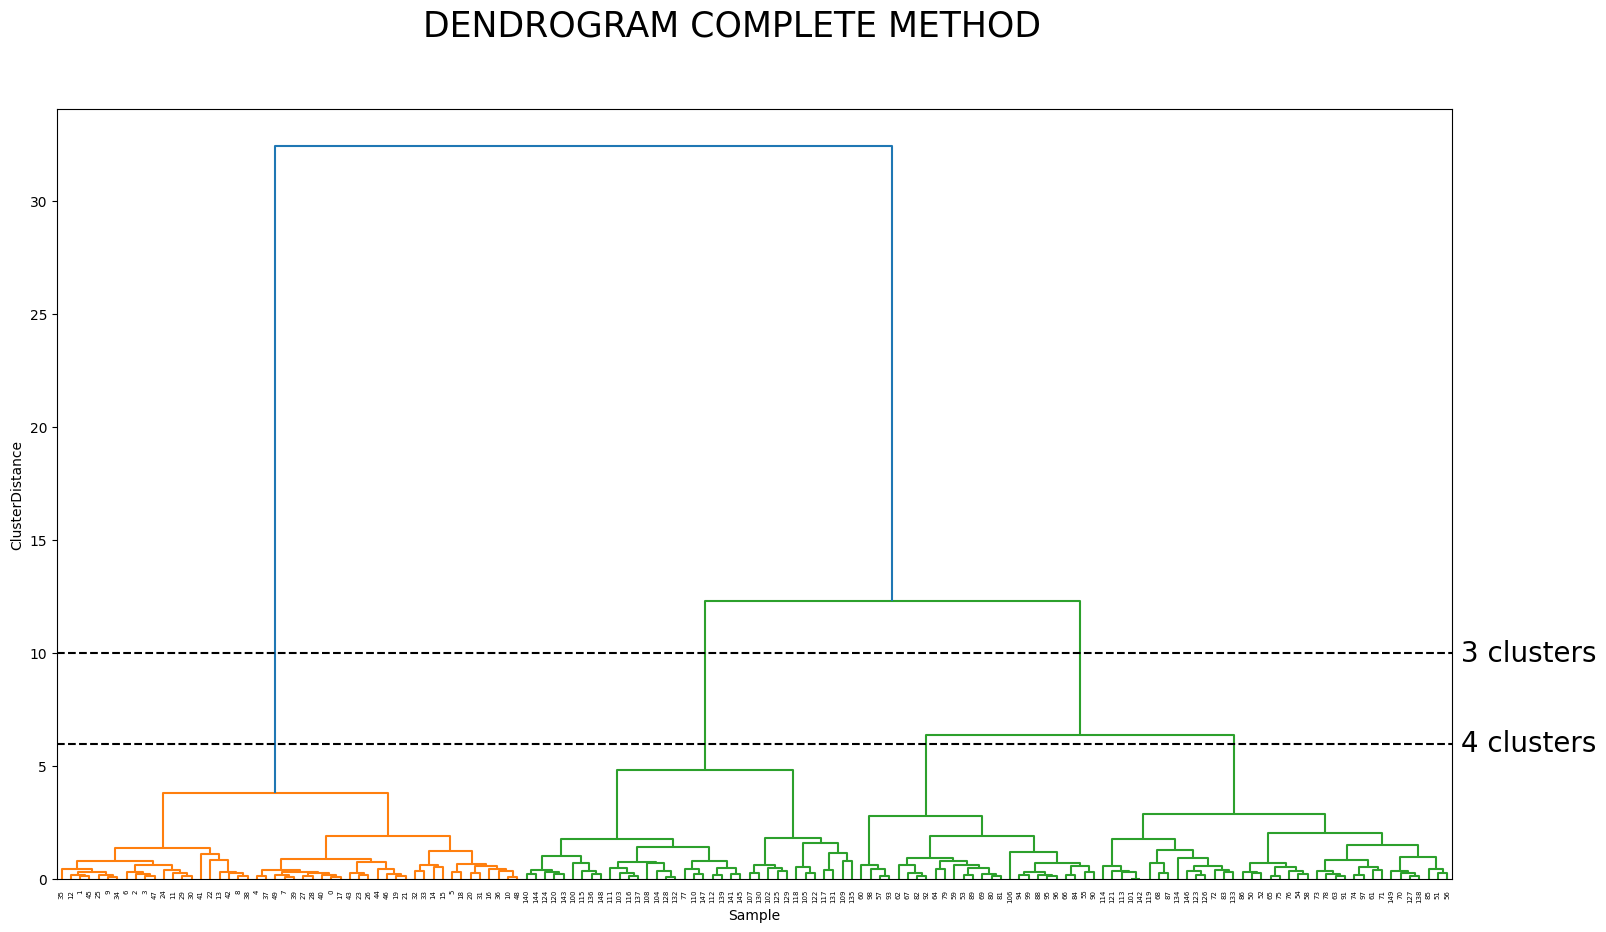

In [25]:
iris.plot_dendrogram()

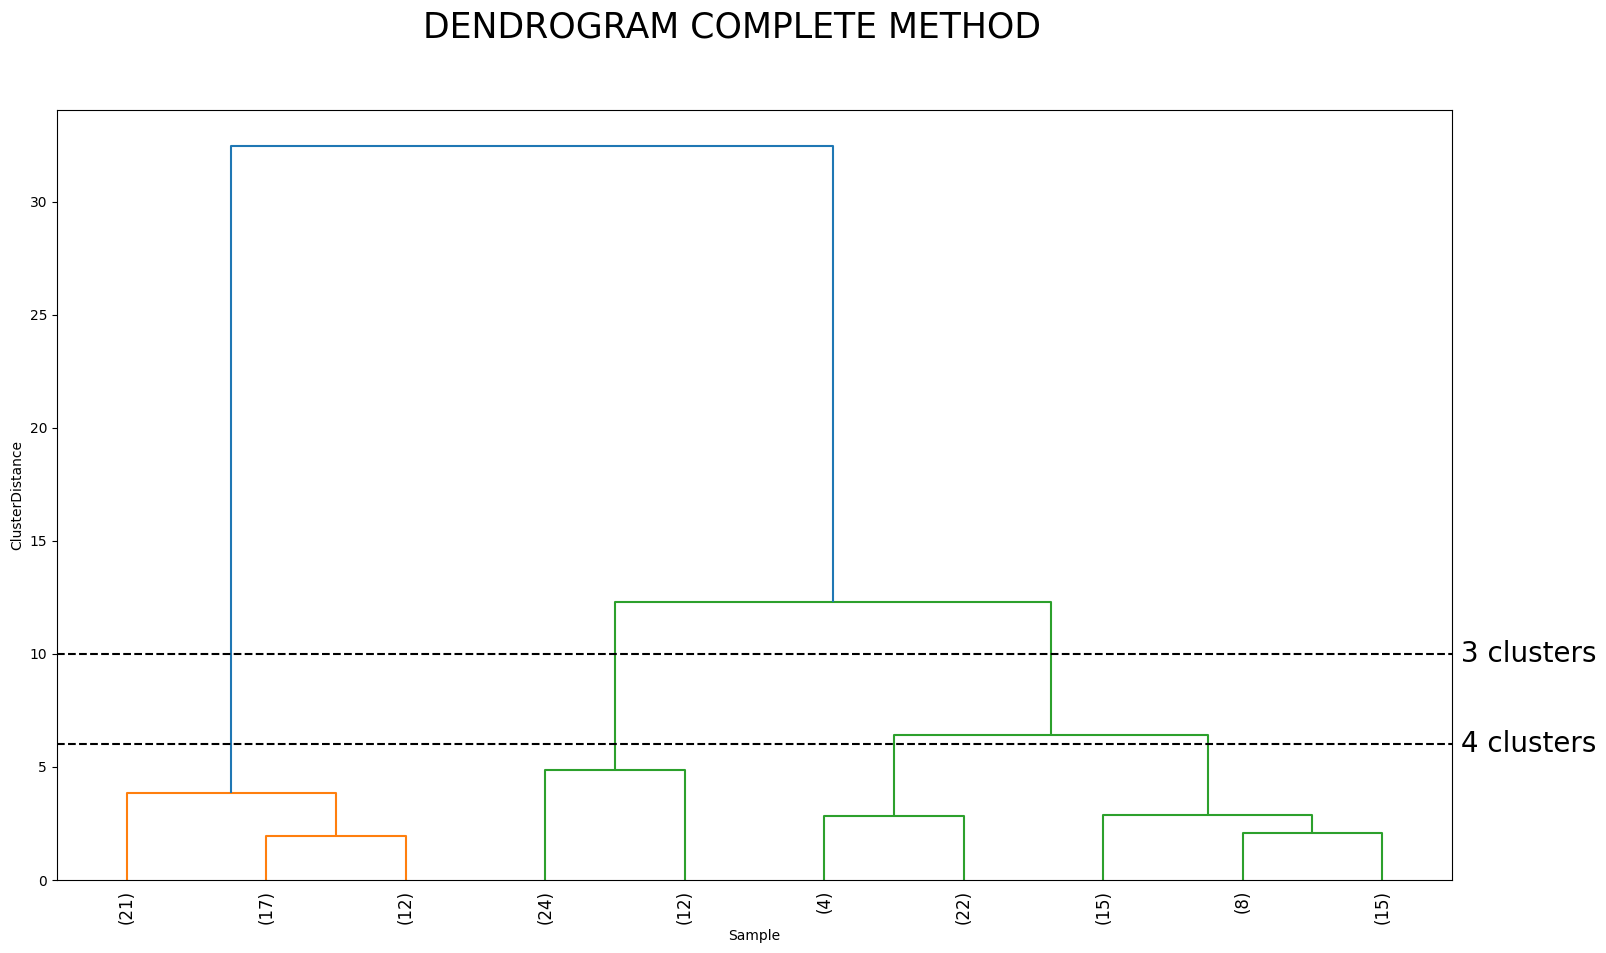

In [26]:
iris.plot_dendrogram(truncate=True)

Cluster Memberships: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1
  1  1 -1  1  1  1  1  1  1 -1 -1  1 -1 -1  1  1  1  1  1  1  1 -1 -1  1
  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]


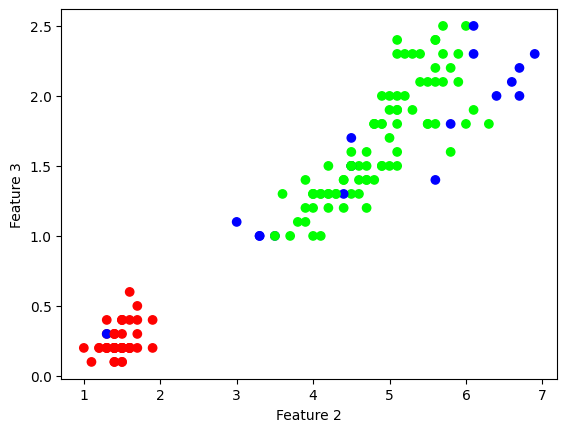

In [27]:
iris.plot_dbscan()

Cluster Memberships: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1 -1 -1  1 -1 -1  1 -1  1  1  1  1  1 -1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1  1  1
  1  1 -1  1 -1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1 -1  1  1 -1 -1 -1
  1  1 -1  1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1
  1  1  1  1 -1  1]


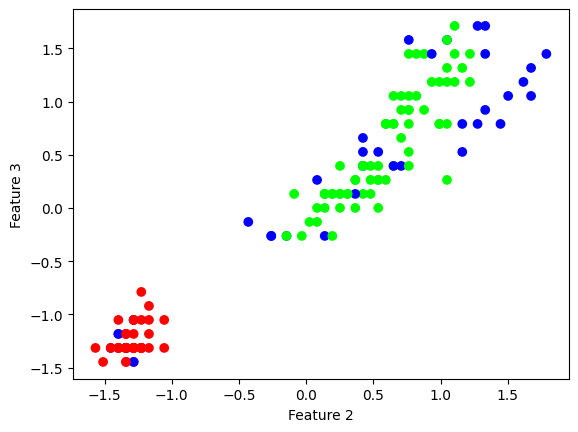

In [28]:
iris.plot_dbscan(scaling=True, eps=0.5, min_samples=5)

# **Use cases of K-Means, Dendrogram and DBSCAN**

*   K-Means: Suitable for well-defined spherical clusters of roughly equal sizes.
*   Dendrogram: Useful for exploring hierarchical structures and choosing the number of clusters at different level.
*   DBSCAN: Effective for finding clusters of arbitrary shapes and handling data with varying density.



